In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score,  balanced_accuracy_score,
                             roc_curve, auc, confusion_matrix, classification_report)
# !pip install xgboost
import xgboost as xgb
# !pip install lightgbm
import lightgbm as lgb
# !pip install catboost
from catboost import CatBoostClassifier
import warnings
import multiprocessing as mp
from datetime import datetime
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             r2_score, mean_absolute_percentage_error)
from catboost import CatBoostRegressor
from scipy import stats

dfClassBalancedFile = "data/df_clean_encoded_train_no_outliers_scaled_classification_balanced.csv"
dfClassImBalancedFile = "data/df_clean_encoded_train_no_outliers_scaled_classification.csv"
dfRegImBalancedFile = "data/df_clean_encoded_train_no_outliers_scaled_regression.csv"

dfClassValFile = "data/df_clean_encoded_validation_classification.csv"
dfClassTestFile = "data/df_clean_encoded_test_classification.csv"
dfRegValFile = "data/df_clean_encoded_validation_regression.csv"
dfRegTestFile = "data/df_clean_encoded_test_regression.csv"

TARGET_COL = 'vote_average'

In [2]:
# Uso 3/4 dei core totali del pc per parallelizzare i processi
total_cores = mp.cpu_count()
n_jobs = int(total_cores * 3 / 4)
print(f"Total cores available: {total_cores}")
print(f"Using {n_jobs} cores for parallel processing")

Total cores available: 24
Using 18 cores for parallel processing


### classificazione

l'approccio che voglio prendere è provare molti classificatori, con parameter grids ampie così da vedere quali di loro, a grandi linee performa meglio

una volta trovato il classificatore "giusto" vado ad esplorare meglio i parametri di quello così da ottimizzare le performance

ovviamente utilizzerò k-fold validation, a 5 per i primi test, e a 20 per i test più granulari

##### parametri e funzioni comuni

In [3]:
# Parameter grids con ~9 combinazioni per ogni classificatore
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2]
    },
    
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    },
    
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    },
    
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50],
        'max_depth': [-1]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6]
    },
    
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6]
    },
    
    'BernoulliNB': {
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
        'binarize': [0.0, 0.5]
        
    }
}

In [4]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'BernoulliNB': BernoulliNB()
}

In [5]:
def train_classifiers(X_train, y_train, X_val, y_val, param_grids, models, n_jobs, cv_folds=5):
    """Train multiple classifiers with GridSearchCV"""
    results = {}
    best_models = {}
    
    print(f"Inizio Grid Search con {cv_folds}-Fold CV su {n_jobs} cores")
    print("=" * 80)
    
    for model_name, model in models.items():
        print(f"\n[{datetime.now().strftime('%H:%M:%S')}] training {model_name}...")
        
        try:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[model_name],
                cv=cv_folds,
                n_jobs=n_jobs,
                scoring='f1_macro',
                verbose=1,
                return_train_score=True
            )
            
            grid_search.fit(X_train, y_train)
            
            best_models[model_name] = grid_search.best_estimator_
            
            train_pred = grid_search.predict(X_train)
            val_pred = grid_search.predict(X_val)
            
            try:
                train_pred_proba = grid_search.predict_proba(X_train)
                val_pred_proba = grid_search.predict_proba(X_val)
                has_proba = True
            except:
                has_proba = False
            
            def calculate_metrics(y_true, y_pred, y_pred_proba=None, set_name=''):
                metrics = {
                    f'{set_name}_accuracy': accuracy_score(y_true, y_pred),
                    f'{set_name}_precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                    f'{set_name}_recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                    f'{set_name}_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                    f'{set_name}_balanced_acc': balanced_accuracy_score(y_true, y_pred),
                }
                
                if y_pred_proba is not None:
                    try:
                        if len(np.unique(y_true)) == 2:
                            metrics[f'{set_name}_roc_auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
                        else:
                            metrics[f'{set_name}_roc_auc'] = roc_auc_score(y_true, y_pred_proba, 
                                                                           multi_class='ovr', average='weighted')
                    except:
                        metrics[f'{set_name}_roc_auc'] = np.nan
                else:
                    metrics[f'{set_name}_roc_auc'] = np.nan
                
                return metrics
            
            model_results = {
                'model_name': model_name,
                'best_params': grid_search.best_params_,
                'cv_mean_score': grid_search.best_score_,
                'cv_std_score': grid_search.cv_results_['std_test_score'][grid_search.best_index_]
            }
            
            model_results.update(calculate_metrics(y_train, train_pred, 
                                                   train_pred_proba if has_proba else None, 'train'))
            model_results.update(calculate_metrics(y_val, val_pred, 
                                                   val_pred_proba if has_proba else None, 'val'))
            
            results[model_name] = model_results
            
            print(f"Miglior CV Score: {grid_search.best_score_:.4f}")
            print(f"Validation Accuracy: {model_results['val_accuracy']:.4f}")
            print(f"Validation Precision: {model_results['val_precision']:.4f}")
            print(f"Validation Recall: {model_results['val_recall']:.4f}")
            print(f"Validation F1: {model_results['val_f1']:.4f}")
            print(f"Validation Balanced accuracy: {model_results['val_balanced_acc']:.4f}")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue
    
    print("\n" + "=" * 80)
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Tutti i modelli sono stati allenati!")
    
    # Crea DataFrame con risultati
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('val_recall', ascending=False)
    
    print("\nCONFRONTO MODELLI SU VALIDATION SET")
    summary_cols = ['cv_mean_score', 'cv_std_score',
                    'train_accuracy', 'train_recall', 'train_f1',
                    'val_accuracy', 'val_recall', 'val_f1',
                    'val_precision', 'val_balanced_acc', 'val_roc_auc']
    
    summary_table = results_df[summary_cols].round(4)
    print(summary_table.to_string())
    
    best_model_name = results_df.index[0]
    print(f"\nMIGLIOR MODELLO (su Validation): {best_model_name}")
    
    return results_df, best_models

In [6]:
def plot_classification_results(results_df, top_n=10):
    """Crea tutti i plot per confrontare i risultati dei classificatori"""
    
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # Plot 1-6: Comparison overview
    fig = plt.figure(figsize=(20, 12))
    
    top_models = results_df.head(top_n)
    
    # 1. Validation Metrics Comparison
    ax1 = plt.subplot(2, 3, 1)
    metrics_to_plot = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_balanced_acc']
    
    x = np.arange(len(top_models))
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        offset = width * (i - 2)
        ax1.bar(x + offset, top_models[metric], width, 
                label=metric.replace('val_', '').replace('_', ' ').title())
    
    ax1.set_xlabel('Models', fontsize=10)
    ax1.set_ylabel('Score', fontsize=10)
    ax1.set_title('Top 10 Models - Validation Metrics Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    ax1.legend(fontsize=8)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Train vs Validation F1 Score
    ax2 = plt.subplot(2, 3, 2)
    x_pos = np.arange(len(top_models))
    ax2.barh(x_pos - 0.2, top_models['train_f1'], 0.4, label='Train F1', alpha=0.8)
    ax2.barh(x_pos + 0.2, top_models['val_f1'], 0.4, label='Validation F1', alpha=0.8)
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels(top_models.index, fontsize=8)
    ax2.set_xlabel('F1 Score', fontsize=10)
    ax2.set_title('Train vs Validation F1 Score\n(Overfitting Check)', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Cross-Validation Scores
    ax3 = plt.subplot(2, 3, 3)
    ax3.errorbar(range(len(top_models)), top_models['cv_mean_score'], 
                 yerr=top_models['cv_std_score'], fmt='o-', capsize=5, 
                 capthick=2, markersize=8, linewidth=2)
    ax3.set_xticks(range(len(top_models)))
    ax3.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    ax3.set_ylabel('CV Score', fontsize=10)
    ax3.set_xlabel('Models', fontsize=10)
    ax3.set_title('Cross-Validation Scores (Mean ± Std)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Heatmap
    ax4 = plt.subplot(2, 3, 4)
    heatmap_metrics = ['cv_mean_score', 'train_f1', 'val_accuracy', 
                       'val_precision', 'val_recall', 'val_f1', 'val_balanced_acc']
    
    heatmap_data = top_models[heatmap_metrics].apply(pd.to_numeric, errors='coerce').T
    heatmap_data = heatmap_data.fillna(0)
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', 
                cbar_kws={'label': 'Score'}, ax=ax4, linewidths=0.5)
    ax4.set_title('Performance Heatmap - All Metrics', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Models', fontsize=10)
    ax4.set_yticklabels([m.replace('_', ' ').title() for m in heatmap_metrics], 
                         rotation=0, fontsize=8)
    ax4.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    
    # 5. Overfitting Analysis
    ax5 = plt.subplot(2, 3, 5)
    overfitting_gap = top_models['train_f1'] - top_models['val_f1']
    colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' 
              for gap in overfitting_gap]
    bars = ax5.barh(range(len(top_models)), overfitting_gap, color=colors, alpha=0.7)
    ax5.set_yticks(range(len(top_models)))
    ax5.set_yticklabels(top_models.index, fontsize=8)
    ax5.set_xlabel('Train F1 - Validation F1', fontsize=10)
    ax5.set_title('Overfitting Analysis\n(Green=Good, Orange=Moderate, Red=High)', 
                  fontsize=12, fontweight='bold')
    ax5.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax5.axvline(x=0.05, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    ax5.axvline(x=0.1, color='red', linestyle=':', linewidth=1, alpha=0.5)
    ax5.grid(axis='x', alpha=0.3)
    
    # 6. ROC-AUC Comparison
    ax6 = plt.subplot(2, 3, 6)
    roc_valid = top_models[['train_roc_auc', 'val_roc_auc']].apply(pd.to_numeric, errors='coerce')
    roc_valid = roc_valid.dropna()
    
    if not roc_valid.empty:
        x_pos = np.arange(len(roc_valid))
        width = 0.35
        ax6.bar(x_pos - width/2, roc_valid['train_roc_auc'], width, 
                label='Train ROC-AUC', alpha=0.8)
        ax6.bar(x_pos + width/2, roc_valid['val_roc_auc'], width, 
                label='Validation ROC-AUC', alpha=0.8)
        ax6.set_xticks(x_pos)
        ax6.set_xticklabels(roc_valid.index, rotation=45, ha='right', fontsize=8)
        ax6.set_ylabel('ROC-AUC Score', fontsize=10)
        ax6.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'ROC-AUC data not available', 
                 ha='center', va='center', fontsize=12)
        ax6.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
        ax6.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 7: Metriche dettagliate
    fig3, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    metrics = ['val_accuracy', 'val_precision', 'val_recall', 
               'val_f1', 'val_balanced_acc', 'cv_mean_score']
    titles = ['Validation Accuracy', 'Validation Precision', 'Validation Recall',
              'Validation F1 Score', 'Validation Balanced Accuracy', 'CV Mean Score']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        metric_data = pd.to_numeric(results_df[metric], errors='coerce')
        sorted_data = results_df.copy()
        sorted_data[metric] = metric_data
        sorted_data = sorted_data.dropna(subset=[metric])
        sorted_data = sorted_data.sort_values(metric, ascending=True)
        
        values = sorted_data[metric].values
        
        if values.max() - values.min() > 0:
            normalized = (values - values.min()) / (values.max() - values.min())
        else:
            normalized = np.ones_like(values) * 0.5
        
        colors_map = plt.cm.RdYlGn(normalized)
        
        axes[idx].barh(range(len(sorted_data)), values, color=colors_map)
        axes[idx].set_yticks(range(len(sorted_data)))
        axes[idx].set_yticklabels(sorted_data.index, fontsize=9)
        axes[idx].set_xlabel('Score', fontsize=10)
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        
        for i, v in enumerate(values):
            axes[idx].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_multiclass_roc_detailed(model, model_name, X, y, classes, title_suffix=''):
    """Plot delle curve ROC dettagliate per classificazione multiclasse"""
    
    y_pred_proba = model.predict_proba(X)
    y_bin = label_binarize(y, classes=classes)
    n_classes = len(classes)
    
    # Calcola curva ROC e area per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calcola micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Calcola macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 
                    'purple', 'brown', 'pink', 'gray', 'olive'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'Class {classes[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
            color='deeppink', linestyle=':', linewidth=3)
    
    plt.plot(fpr["macro"], tpr["macro"],
            label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
            color='navy', linestyle=':', linewidth=3)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curves by Class {title_suffix}', 
              fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    
    return plt.gcf()

#### dataset bilanciato prima analisi

In [8]:
df = pd.read_csv(dfClassBalancedFile)
dfVal = pd.read_csv(dfClassValFile)

In [9]:
X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_val = dfVal.drop(columns=[TARGET_COL])
y_val = dfVal[TARGET_COL]

In [10]:
# Esegui training
results_df, best_models = train_classifiers(
    X_train, y_train, 
    X_val, y_val, 
    param_grids, 
    models, 
    n_jobs,
    cv_folds=5
)

Inizio Grid Search con 5-Fold CV su 18 cores

[22:39:07] training RandomForest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Miglior CV Score: 0.6547
Validation Accuracy: 0.3992
Validation Precision: 0.4638
Validation Recall: 0.3992
Validation F1: 0.4217
Validation Balanced accuracy: 0.3776

[22:39:32] training SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV Score: 0.4307
Validation Accuracy: 0.3179
Validation Precision: 0.4485
Validation Recall: 0.3179
Validation F1: 0.3614
Validation Balanced accuracy: 0.2165

[22:40:38] training AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Miglior CV Score: 0.3025
Validation Accuracy: 0.1327
Validation Precision: 0.0937
Validation Recall: 0.1327
Validation F1: 0.0982
Validation Balanced accuracy: 0.3425

[22:40:48] training GradientBoosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV Score: 0.6159
Validation Accuracy: 0.4023
Validation Precision

  File "c:\Users\Ale\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Ale\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Ale\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 947, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Ale\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 1416, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Miglior CV Score: 0.6464
Validation Accuracy: 0.4115
Validation Precision: 0.4741
Validation Recall: 0.4115
Validation F1: 0.4312
Validation Balanced accuracy: 0.3942

[22:49:46] training XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV Score: 0.6307
Validation Accuracy: 0.3971
Validation Precision: 0.4600
Validation Recall: 0.3971
Validation F1: 0.4172
Validation Balanced accuracy: 0.3836

[22:50:01] training CatBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV Score: 0.6164
Validation Accuracy: 0.4331
Validation Precision: 0.5029
Validation Recall: 0.4331
Validation F1: 0.4556
Validation Balanced accuracy: 0.3984

[22:50:34] training BernoulliNB...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Miglior CV Score: 0.2361
Validation Accuracy: 0.2222
Validation Precision: 0.4493
Validation Recall: 0.2222
Validation F1: 0.2419
Validation Balanced accuracy: 0.1968

[22:50:34] Tutti i modelli sono stati allenati!

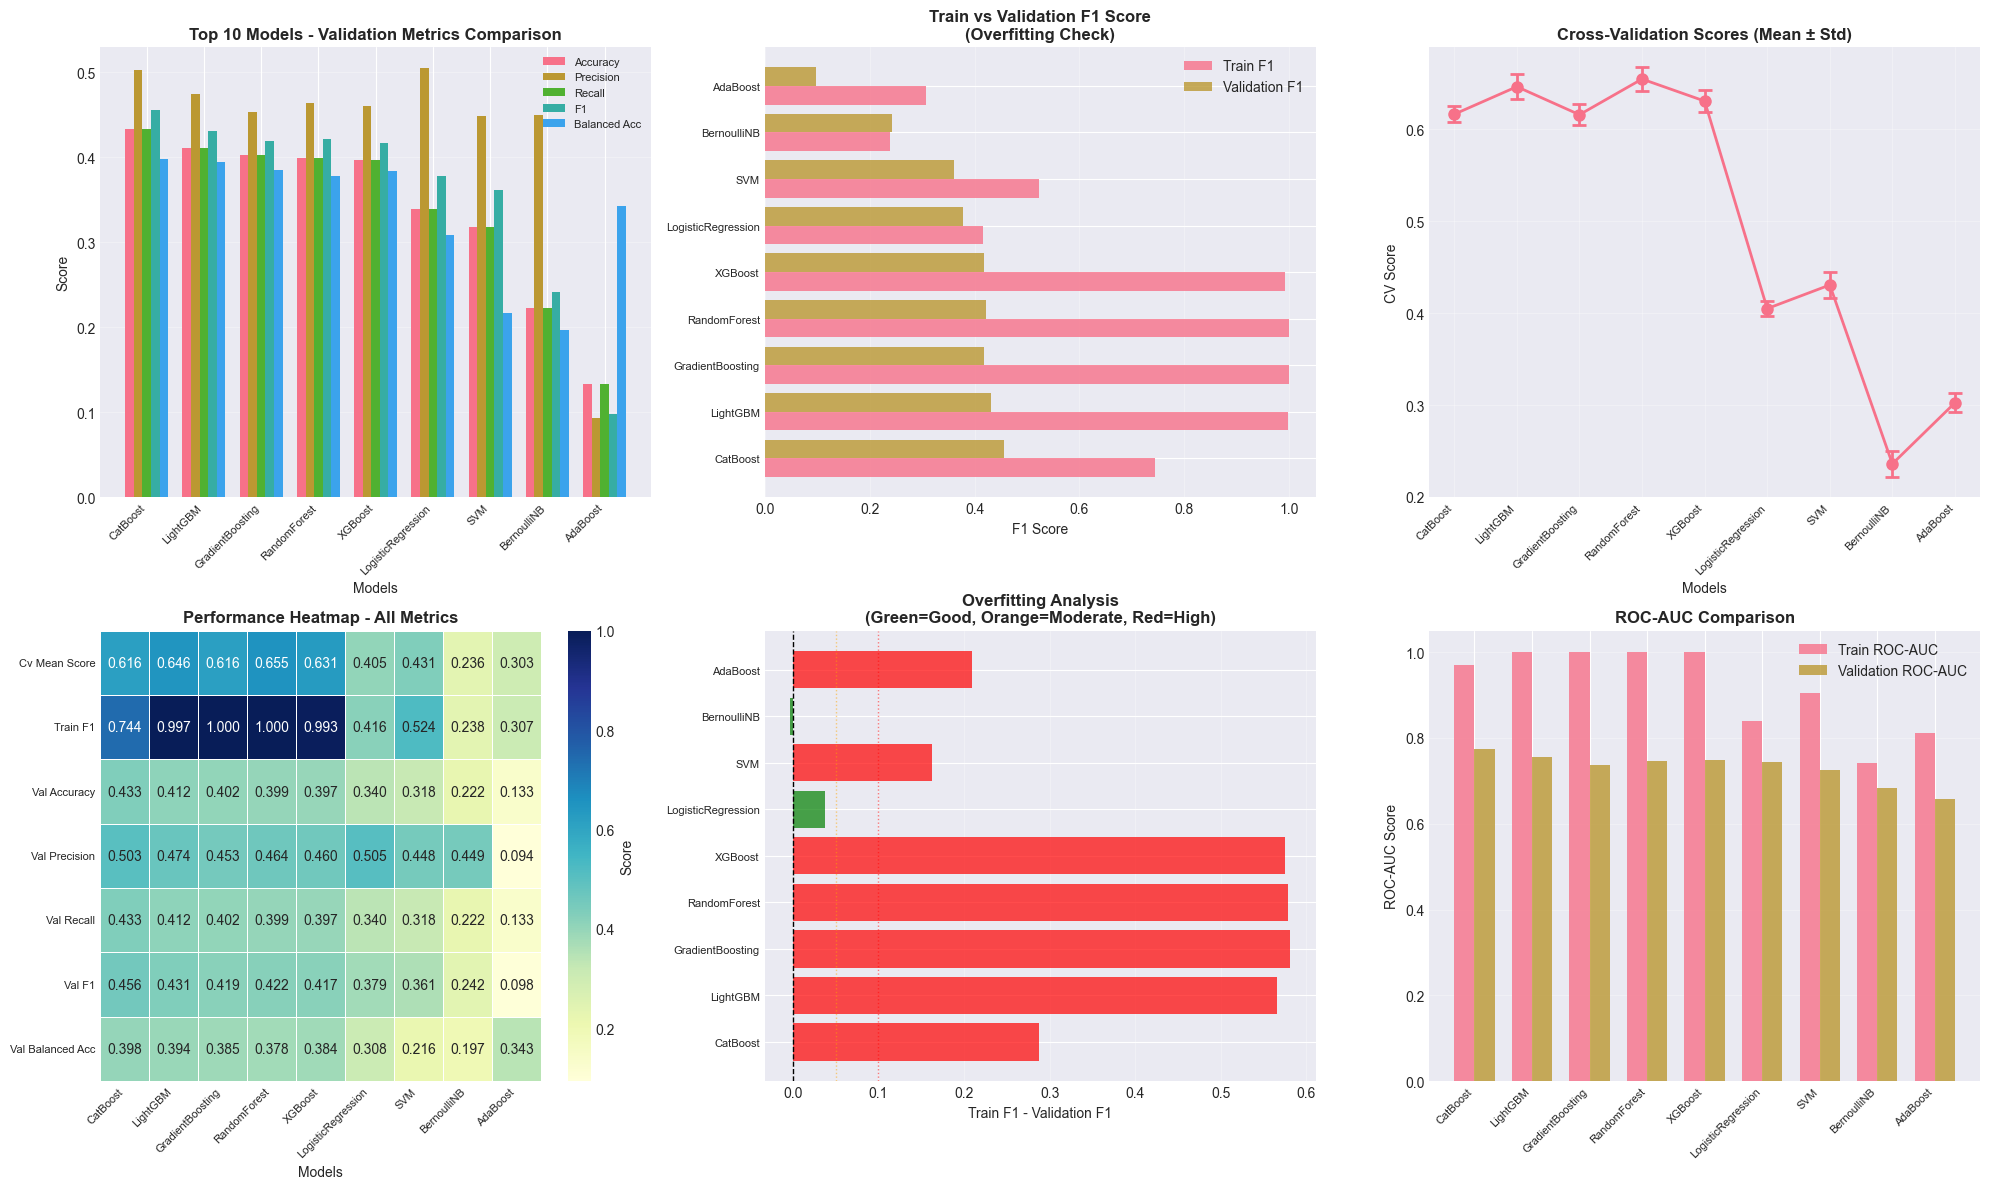

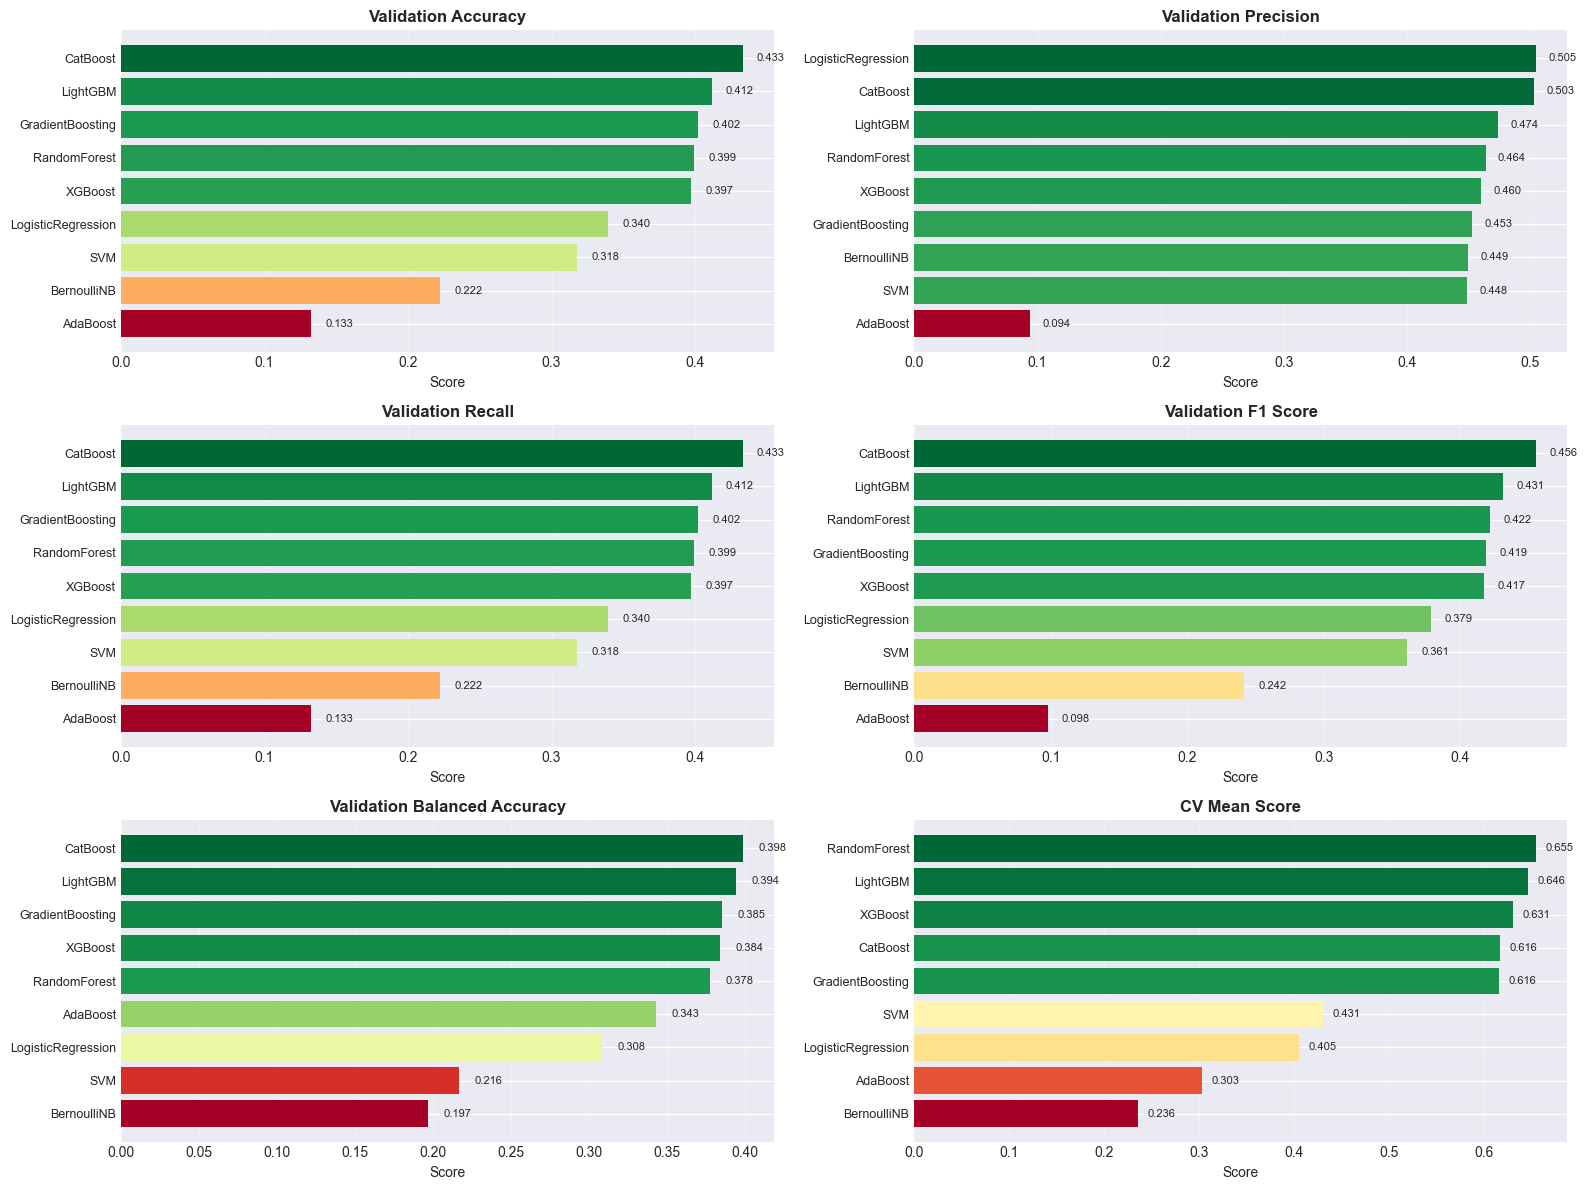

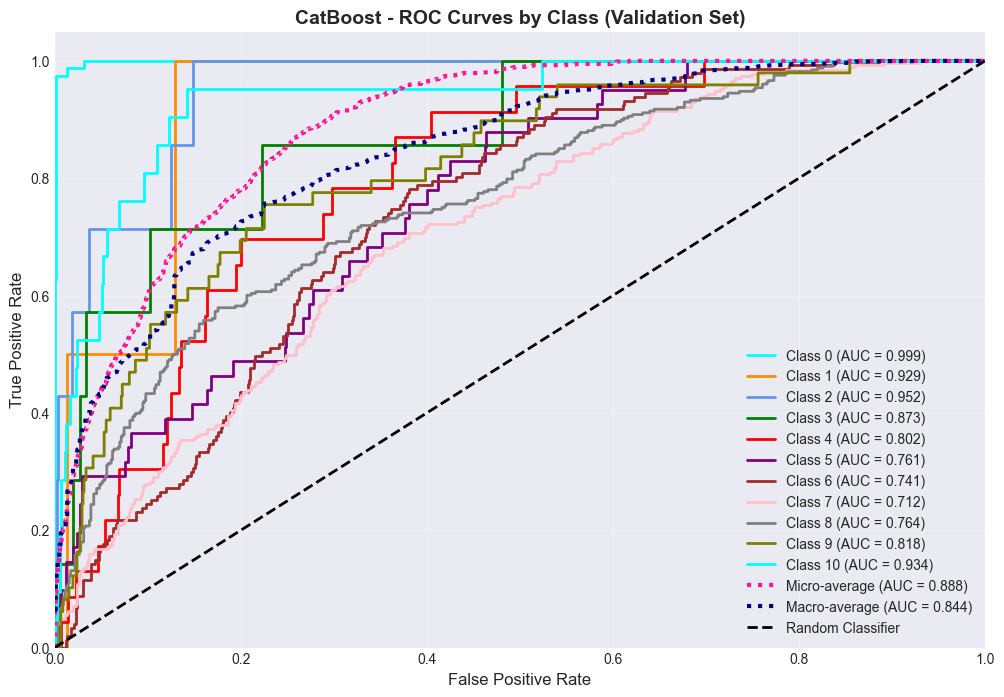

In [11]:
# Crea i plot
plot_classification_results(results_df, top_n=10)

# Plot ROC per il miglior modello
classes = np.unique(y_val)
best_model_name = results_df.index[0]
best_model = best_models[best_model_name]

fig = plot_multiclass_roc_detailed(
    best_model, 
    best_model_name, 
    X_val, 
    y_val, 
    classes, 
    '(Validation Set)'
)
plt.show()

#### dataset non bilanciato prima analisi

In [12]:
df = pd.read_csv(dfClassImBalancedFile)
dfVal = pd.read_csv(dfClassValFile)

In [13]:
X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_val = dfVal.drop(columns=[TARGET_COL])
y_val = dfVal[TARGET_COL]

In [14]:
# Esegui training
results_df, best_models = train_classifiers(
    X_train, y_train, 
    X_val, y_val, 
    param_grids, 
    models, 
    n_jobs,
    cv_folds=5
)

Inizio Grid Search con 5-Fold CV su 18 cores

[22:50:36] training RandomForest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Miglior CV Score: 0.2708
Validation Accuracy: 0.4784
Validation Precision: 0.4496
Validation Recall: 0.4784
Validation F1: 0.4615
Validation Balanced accuracy: 0.2700

[22:50:59] training SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV Score: 0.1733
Validation Accuracy: 0.4290
Validation Precision: 0.3862
Validation Recall: 0.4290
Validation F1: 0.3927
Validation Balanced accuracy: 0.1896

[22:52:20] training AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Miglior CV Score: 0.1716
Validation Accuracy: 0.1420
Validation Precision: 0.3928
Validation Recall: 0.1420
Validation F1: 0.1546
Validation Balanced accuracy: 0.2238

[22:52:27] training GradientBoosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV Score: 0.2832
Validation Accuracy: 0.4887
Validation Precision

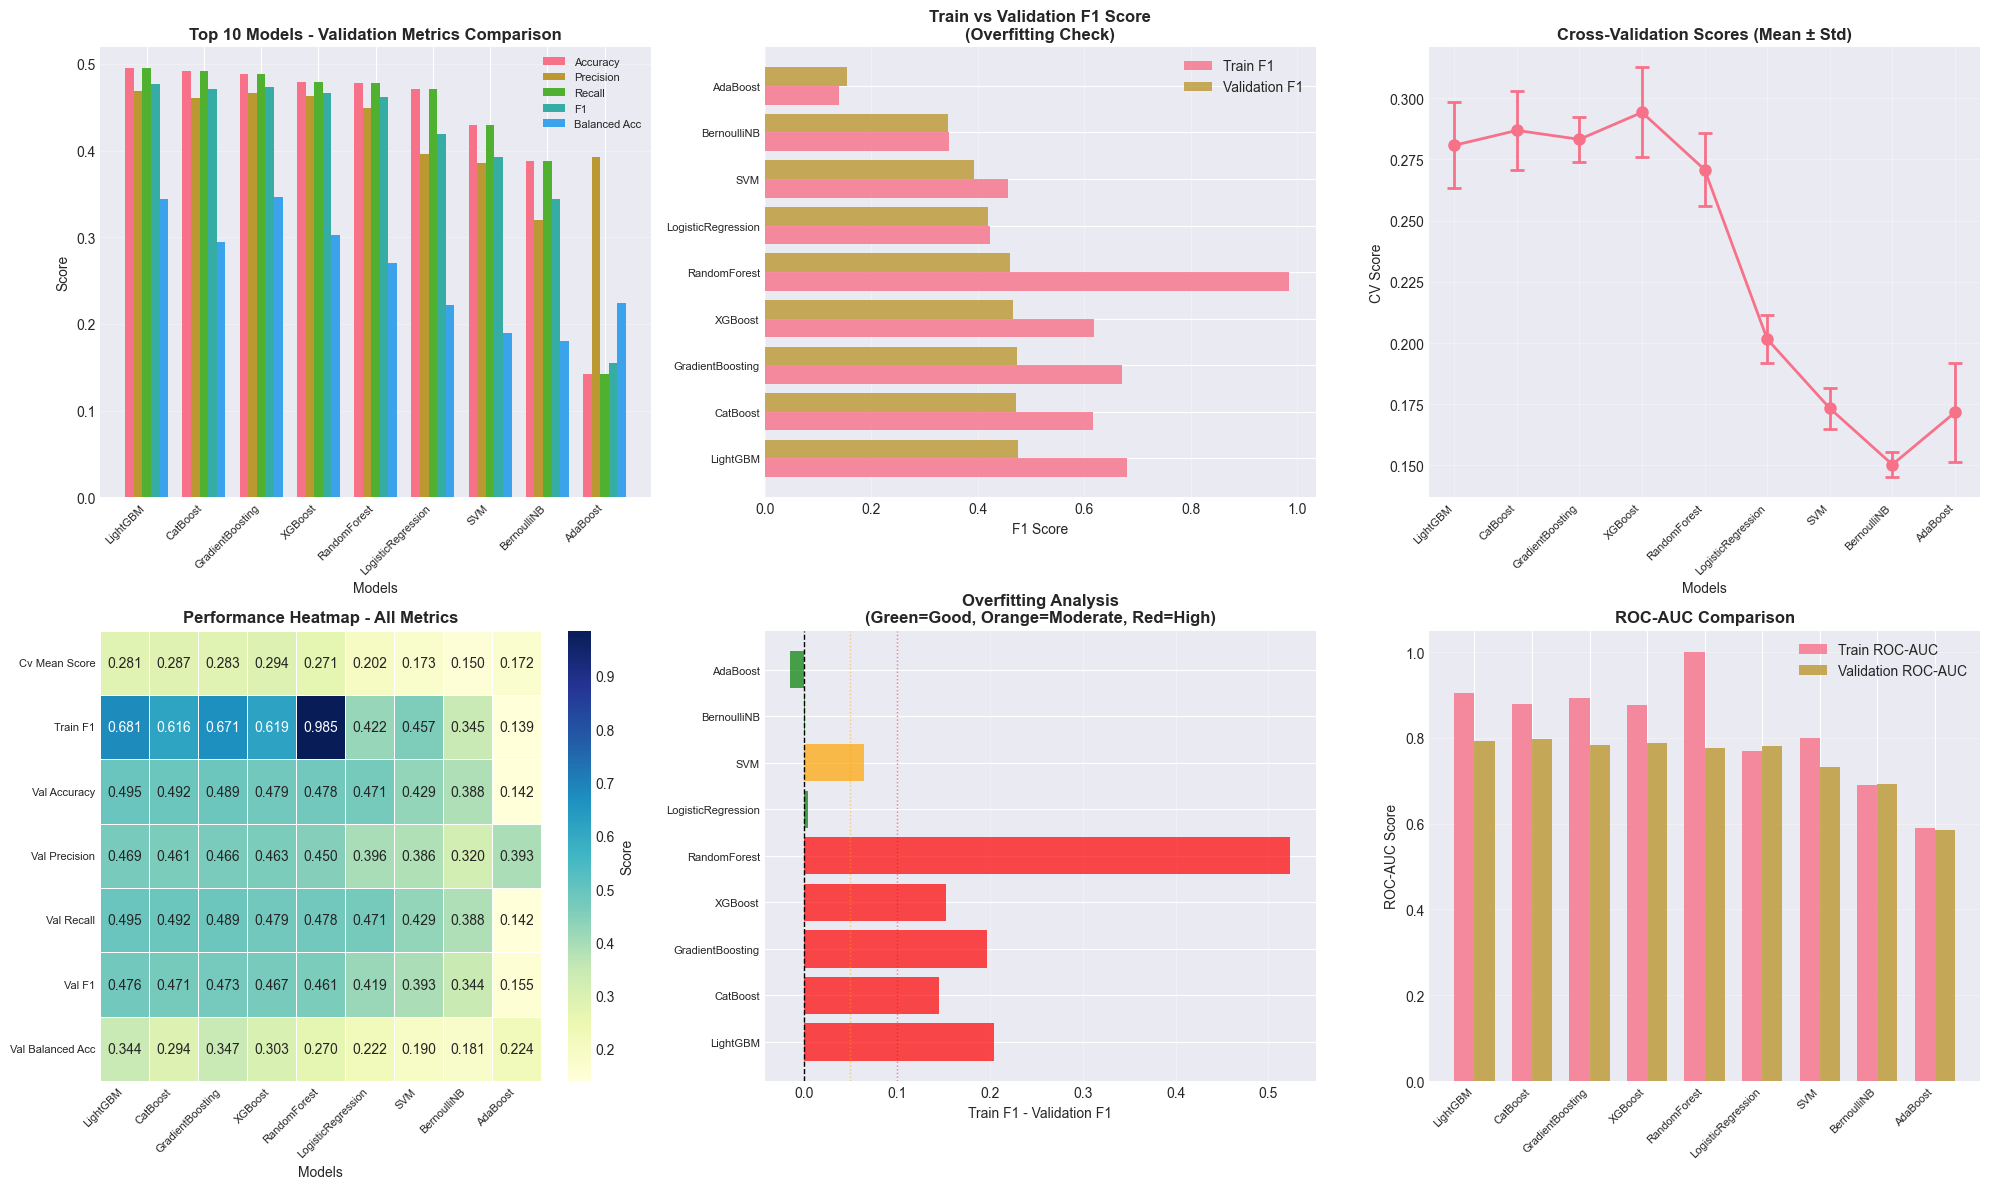

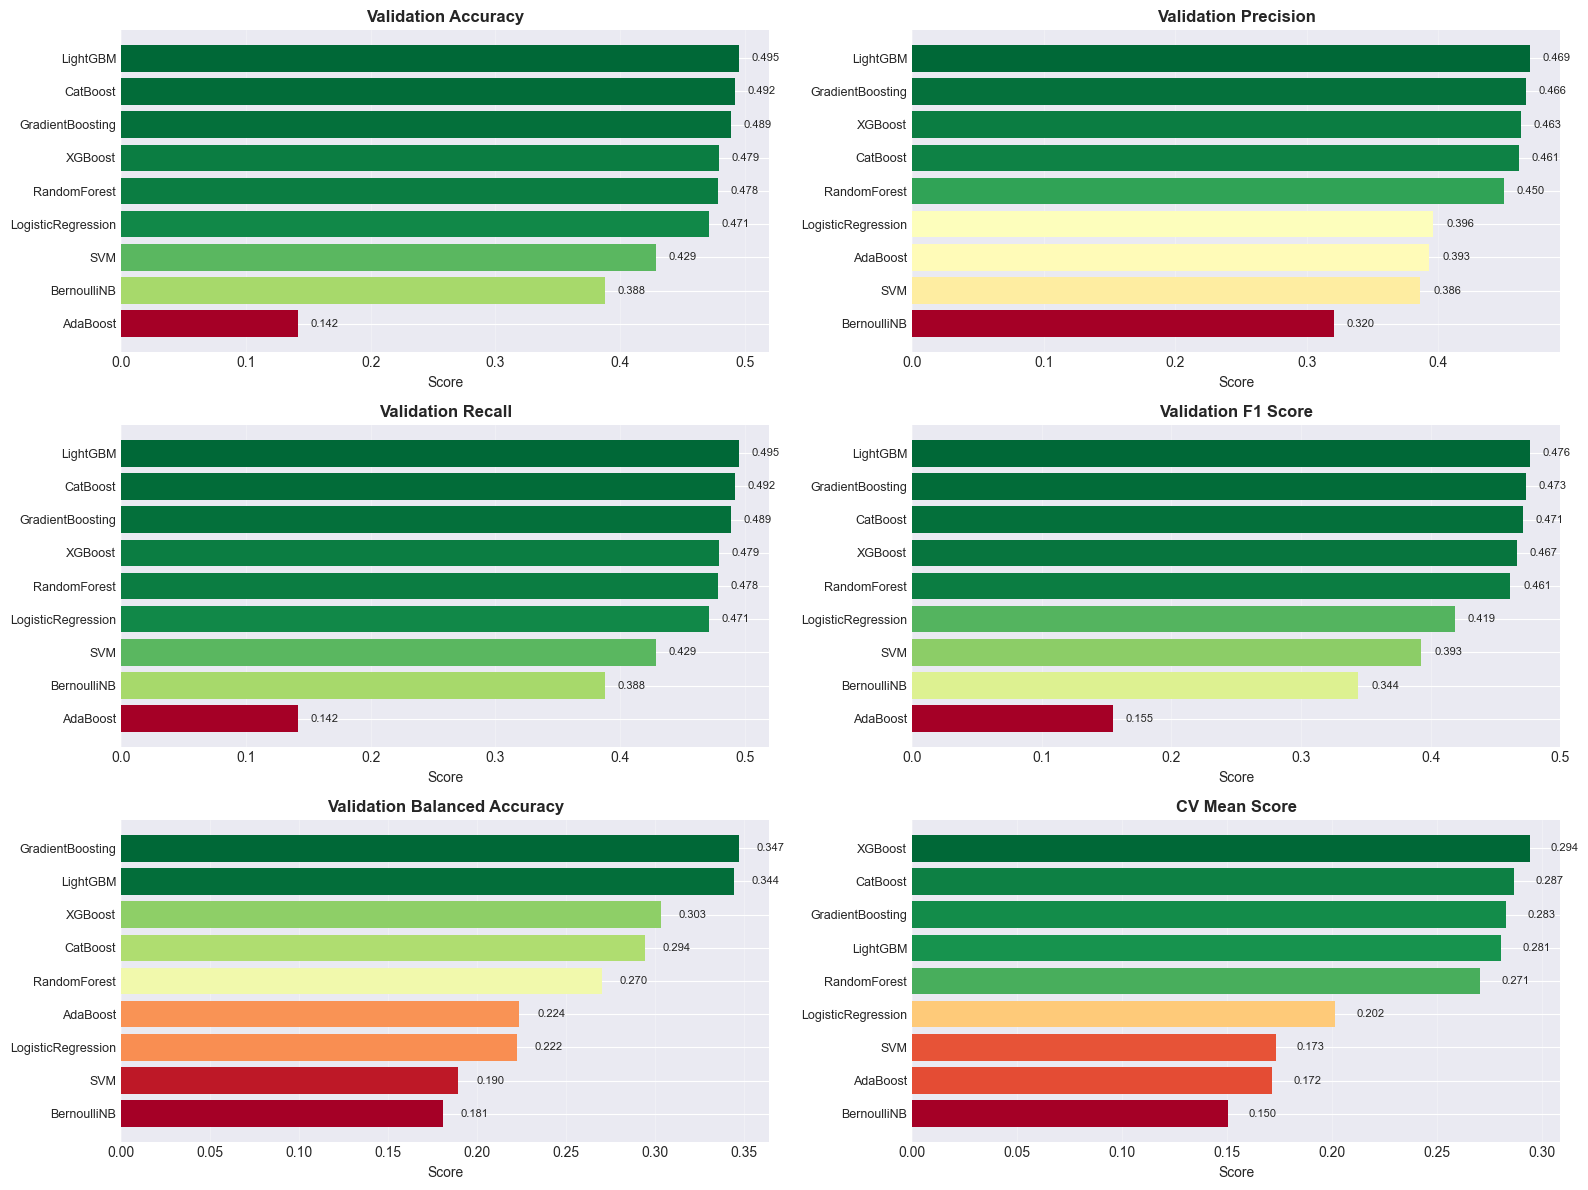

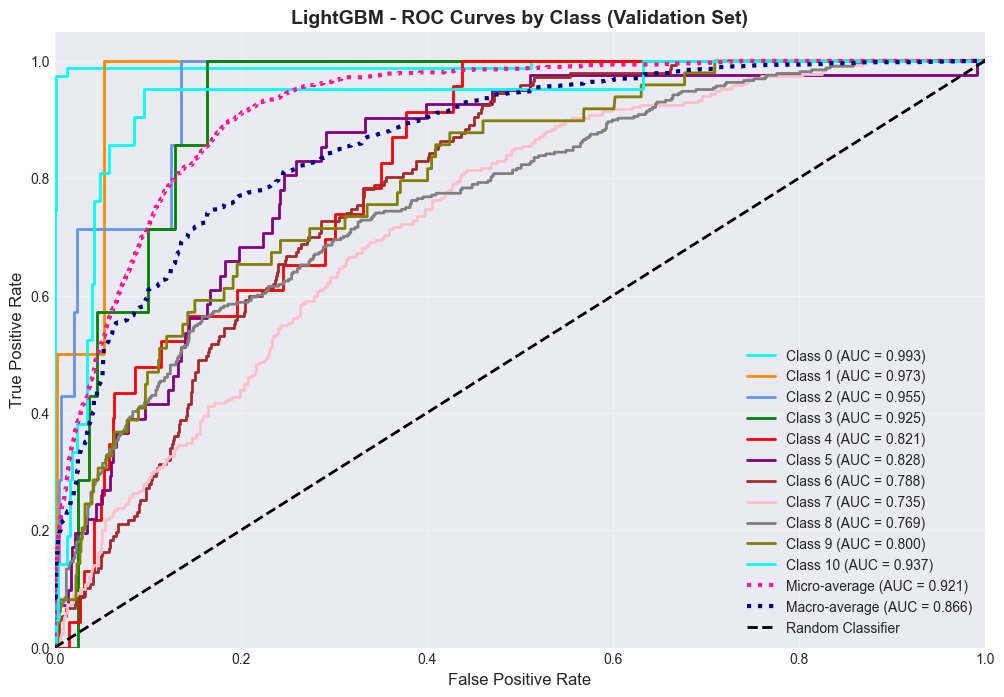

In [15]:
# Crea i plot
plot_classification_results(results_df, top_n=10)

# Plot ROC per il miglior modello
classes = np.unique(y_val)
best_model_name = results_df.index[0]
best_model = best_models[best_model_name]

fig = plot_multiclass_roc_detailed(
    best_model, 
    best_model_name, 
    X_val, 
    y_val, 
    classes, 
    '(Validation Set)'
)
plt.show()

### riassunto e fine tuning

come visto dagli output e grafici sopra riportati il dataset non bilanciato ottiene performance migliori sul set di validazione rispetto a quello bilanciato

inoltre LightGBM, modello che performa meglio per il dataset non bilanciato, ottiene delle metriche più alte sia per quanto riguarda accuracy, recall,... sia per la metrica riguardante l'overfitting rispetto a CatBoost (modello meglio performante sul dataset bilanciato)

proseguo quindi con il fine tuning del modello sul dataset non bilanciato, sapendo inoltre di, probabilmente, non avere problemi per quanto riguarda il regressore che andrò ad implementare successivamente

In [16]:
df = pd.read_csv(dfClassImBalancedFile)
dfVal = pd.read_csv(dfClassValFile)

X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_val = dfVal.drop(columns=[TARGET_COL])
y_val = dfVal[TARGET_COL]

siccome nella funzione di prima non ho salvato la combinazione di parametri migliori per non affollare l'ouptut rialleno il modello con la parametr grid precedente per trovare i parametri dei test precedenti

In [17]:
initial_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1]
}

In [18]:
print(f"\nTesting {np.prod([len(v) for v in initial_param_grid.values()])} parameter combinations")

initial_grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_grid=initial_param_grid,
    cv=5,
    n_jobs=n_jobs,
    scoring='f1_macro',
    verbose=2,
    return_train_score=True
)

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Starting initial grid search...")
initial_grid_search.fit(X_train, y_train)
print(f"[{datetime.now().strftime('%H:%M:%S')}] Initial grid search completed!")


Testing 8 parameter combinations

[23:00:15] Starting initial grid search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[23:02:35] Initial grid search completed!


In [19]:
print(f"Best CV Score: {initial_grid_search.best_score_:.4f}")
print(f"Best Parameters: {initial_grid_search.best_params_}")

initial_best_model = initial_grid_search.best_estimator_
val_pred = initial_best_model.predict(X_val)

print("\nValidation Set Metrics:")
print(f"  Accuracy: {accuracy_score(y_val, val_pred):.4f}")
print(f"  Precision: {precision_score(y_val, val_pred, average='weighted'):.4f}")
print(f"  Recall: {recall_score(y_val, val_pred, average='weighted'):.4f}")
print(f"  F1 Score: {f1_score(y_val, val_pred, average='weighted'):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, val_pred):.4f}")

Best CV Score: 0.2808
Best Parameters: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50}

Validation Set Metrics:
  Accuracy: 0.4949
  Precision: 0.4693
  Recall: 0.4949
  F1 Score: 0.4764
  Balanced Accuracy: 0.3444


vado poi a creare una nuova parametr grid con un po' di rumore sui parametri migliori trovati ed estendendo i parametri che imposto

In [20]:
initial_best_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 50,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

In [21]:
# https://lightgbm.readthedocs.io/en/stable/Parameters.html
fine_tune_param_grid_light = {
    'n_estimators': [
        200, 150, 250
    ],
    'learning_rate': [
        0.01, 0.005, 0.015
    ],
    'num_leaves': [
        50, 30, 70
    ],
    'max_depth': [-1, 10, 30],
    # ho deciso di rimuovere gli altri parametri in quanto ci avrebbe messo troppo tempo
    # 'min_child_samples': [20, 10, 30],
    # 'subsample': [1.0, 0.8],
    # 'colsample_bytree': [1.0, 0.8],
    # 'reg_alpha': [0, 0.1],
    # 'reg_lambda': [0, 0.1]
}

In [22]:
serializationFile = "output/classification_fine_tune_grid_search_light.pkl"
if not os.path.isfile(serializationFile):
    fine_tune_grid_search_light = GridSearchCV(
        estimator=lgb.LGBMClassifier(random_state=42, verbose=-1),
        param_grid=fine_tune_param_grid_light,
        cv=10,
        n_jobs=n_jobs,
        scoring='f1_macro',
        verbose=4,
        return_train_score=True
    )

    print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Starting light fine-tuning...")
    fine_tune_grid_search_light.fit(X_train, y_train)
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Light fine-tuning completed!")
    with open (serializationFile, "wb") as f:
        pickle.dump(fine_tune_grid_search_light, f)
        
with open (serializationFile, "rb") as f:
    fine_tune_grid_search_light = pickle.load(f)


[23:02:35] Starting light fine-tuning...
Fitting 10 folds for each of 81 candidates, totalling 810 fits
[00:18:16] Light fine-tuning completed!


In [23]:
print(f"Best CV Score: {fine_tune_grid_search_light.best_score_:.4f}")
print(f"Best Parameters: {fine_tune_grid_search_light.best_params_}")

fine_tuned_model = fine_tune_grid_search_light.best_estimator_
val_pred_ft = fine_tuned_model.predict(X_val)

print("\nValidation Set Metrics:")
print(f"  Accuracy: {accuracy_score(y_val, val_pred_ft):.4f}")
print(f"  Precision: {precision_score(y_val, val_pred_ft, average='weighted'):.4f}")
print(f"  Recall: {recall_score(y_val, val_pred_ft, average='weighted'):.4f}")
print(f"  F1 Score: {f1_score(y_val, val_pred_ft, average='weighted'):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, val_pred_ft):.4f}")

Best CV Score: 0.2956
Best Parameters: {'learning_rate': 0.015, 'max_depth': 10, 'n_estimators': 250, 'num_leaves': 70}

Validation Set Metrics:
  Accuracy: 0.5082
  Precision: 0.4824
  Recall: 0.5082
  F1 Score: 0.4918
  Balanced Accuracy: 0.3064


In [24]:
comparison_data = {
    'Model': ['Initial', 'Light Fine-Tuned'],
    'CV Score': [
        initial_grid_search.best_score_,
        fine_tune_grid_search_light.best_score_,
    ],
    'Val F1': [
        f1_score(y_val, val_pred, average='weighted'),
        f1_score(y_val, val_pred_ft, average='weighted'),
    ],
    'Val Accuracy': [
        accuracy_score(y_val, val_pred),
        accuracy_score(y_val, val_pred_ft),
    ],
    'Val Recall': [
        recall_score(y_val, val_pred, average='weighted'),
        recall_score(y_val, val_pred_ft, average='weighted'),
    ],
    'Val Precision': [
        precision_score(y_val, val_pred, average='weighted'),
        precision_score(y_val, val_pred_ft, average='weighted'),
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("MODEL COMPARISON")
print(comparison_df.to_string(index=False))

MODEL COMPARISON
           Model  CV Score   Val F1  Val Accuracy  Val Recall  Val Precision
         Initial  0.280790 0.476352      0.494856    0.494856       0.469256
Light Fine-Tuned  0.295641 0.491798      0.508230    0.508230       0.482363


come è possibile vedere dall'output precedente i risultati sono migliorati ma di molto poco, non essendo totalmente necessario per il task dato trovare i parametri migliori in assoluto decido di fermarmi qui avendo i parametri migliori per il dataset volto alla classificazione:
* modello: lightgbm, con parametri: 
    * 'learning_rate': 0.015, 
    * 'max_depth': 10, 
    * 'n_estimators': 250, 
    * 'num_leaves': 70

eventualmente avrei potuto continuare la ricerca dei parametri migliori aggiornando il dizionario fine_tune_param_grid_light e cercando i nuovi parametri in base ai risultati ottenuti, la parameter grid al prossimo step sarebbe potuta essere quella riportata qui sotto:

In [25]:
# https://lightgbm.readthedocs.io/en/stable/Parameters.html
fine_tune_param_grid_light = {
    'n_estimators': [
        250, 300, 350
    ],
    'learning_rate': [
        0.015, 0.0225, 0.03,
    ],
    'num_leaves': [
        70, 100, 130
    ],
    'max_depth': [7, 10, 13],
    # lasciando gli altri parametri sempre commentati così da non avere una computazione troppo lunga
    # 'min_child_samples': [20, 10, 30],
    # 'subsample': [1.0, 0.8],
    # 'colsample_bytree': [1.0, 0.8],
    # 'reg_alpha': [0, 0.1],
    # 'reg_lambda': [0, 0.1]
}

l'aggiornamento sopra riportato segue questa logica:
* sia n_estimators che learning_rate che num_leaves hanno preso il valore all'estremo destro quindi aumento i valori di questi, sempre mantenendo gli intervalli precedentemente definiti (e.g. +-50 per n_estimators)
* max_depth invece ha trovato il parametro migliore in mezzo alla lista iniziale ([-1, 10, 30] (per quanto -1 indichi l'assenza di un limite per la profondità degli alberi)), quindi cerco il valore migliore intorno a quello (aggiungendo e rimuovendo 3 di profondità)

#### training modello finale

In [26]:
df = pd.read_csv(dfClassImBalancedFile)
dfTest = pd.read_csv(dfClassTestFile)

X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_test = dfTest.drop(columns=[TARGET_COL])
y_test = dfTest[TARGET_COL]

clf = lgb.LGBMClassifier(learning_rate=0.015, max_depth=10, n_estimators=250, num_leaves=70, random_state=42, verbose=-1)
clf.fit(X_train, y_train)


LGBMClassifier(learning_rate=0.015, max_depth=10, n_estimators=250,
               num_leaves=70, random_state=42, verbose=-1)

In [27]:
y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)

In [28]:
print("TEST SET METRICS - FINAL MODEL (LightGBM)")

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_test),
    'Precision (weighted)': precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
    'Recall (weighted)': recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
    'F1 Score (weighted)': f1_score(y_test, y_pred_test, average='weighted', zero_division=0),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
}
test_metrics['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba_test, 
                                            multi_class='ovr', average='weighted')

for metric, value in test_metrics.items():
    print(f"{metric:.<40} {value:.4f}")

TEST SET METRICS - FINAL MODEL (LightGBM)
Accuracy................................ 0.4928
Precision (weighted).................... 0.4700
Recall (weighted)....................... 0.4928
F1 Score (weighted)..................... 0.4768
Balanced Accuracy....................... 0.2940
ROC-AUC................................. 0.7878


In [29]:
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9873    0.9936       157
           1     0.0000    0.0000    0.0000         5
           2     0.3750    0.2308    0.2857        13
           3     0.3333    0.0714    0.1176        14
           4     0.1379    0.0889    0.1081        45
           5     0.0938    0.0366    0.0526        82
           6     0.2993    0.2789    0.2887       294
           7     0.4395    0.5000    0.4678       538
           8     0.5708    0.6387    0.6029       656
           9     0.2500    0.0918    0.1343        98
          10     0.2321    0.3095    0.2653        42

    accuracy                         0.4928      1944
   macro avg     0.3393    0.2940    0.3015      1944
weighted avg     0.4700    0.4928    0.4768      1944



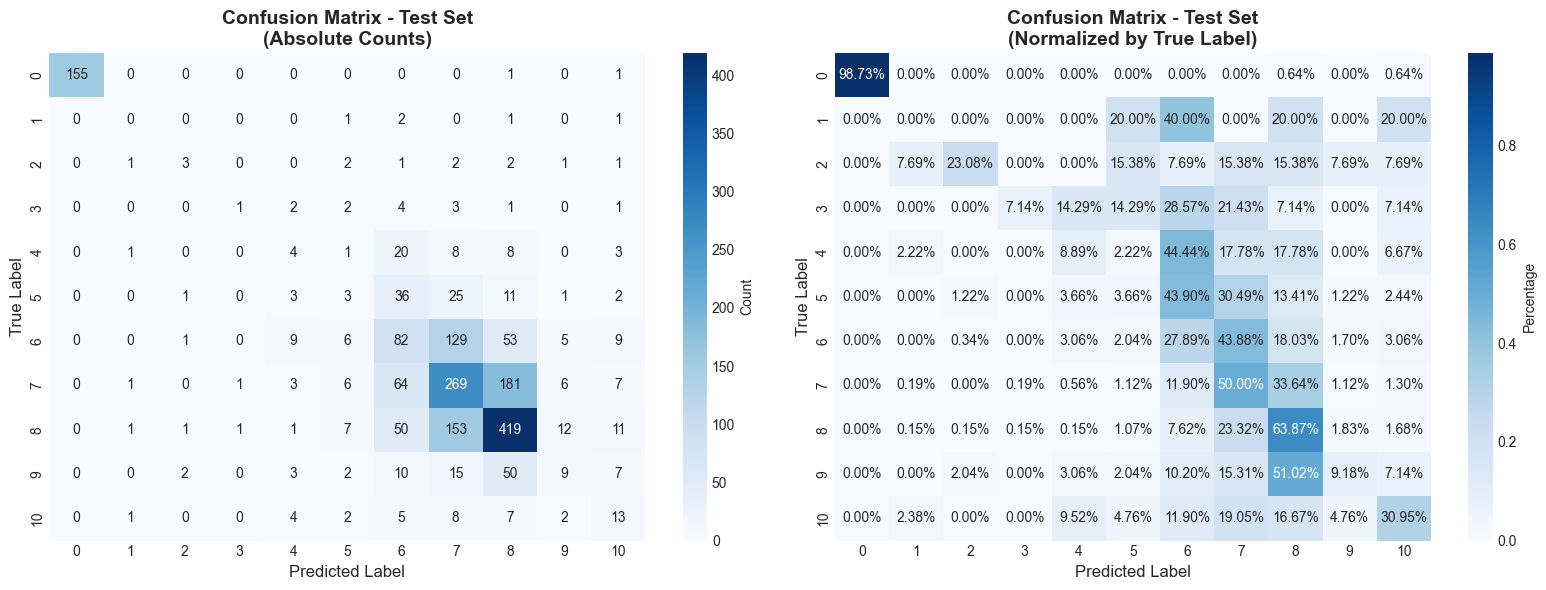

In [30]:
# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix (counts)
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Test Set\n(Absolute Counts)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Confusion Matrix (normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix - Test Set\n(Normalized by True Label)', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

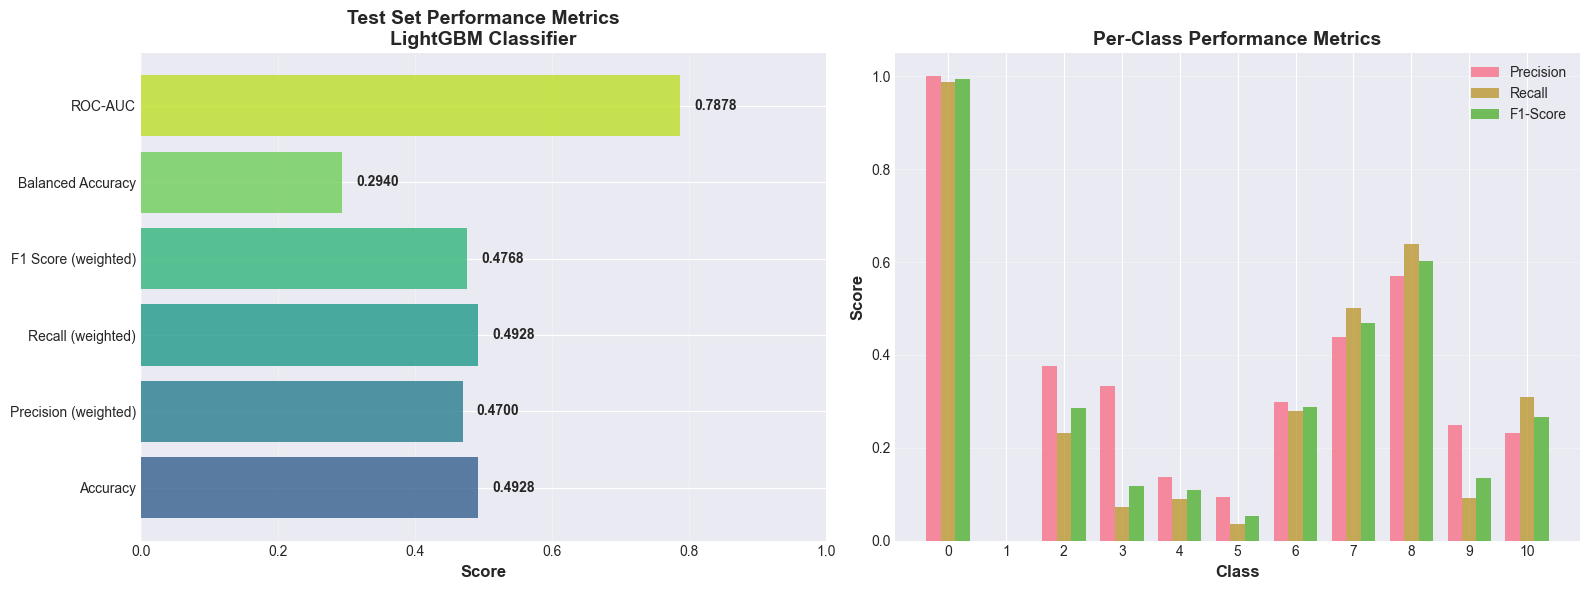

In [31]:
# Test set metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of all metrics
ax1 = axes[0]
metrics_names = list(test_metrics.keys())
metrics_values = list(test_metrics.values())

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(metrics_names)))
bars = ax1.barh(metrics_names, metrics_values, color=colors, alpha=0.8)

ax1.set_xlim([0, 1])
ax1.set_xlabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Test Set Performance Metrics\nLightGBM Classifier', 
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    if not np.isnan(value):
        ax1.text(value + 0.02, i, f'{value:.4f}', 
                va='center', fontsize=10, fontweight='bold')

# Per-class metrics
ax2 = axes[1]
classes = np.unique(y_test)

precision_per_class = precision_score(y_test, y_pred_test, average=None, zero_division=0)
recall_per_class = recall_score(y_test, y_pred_test, average=None, zero_division=0)
f1_per_class = f1_score(y_test, y_pred_test, average=None, zero_division=0)

x_pos = np.arange(len(classes))
width = 0.25

ax2.bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8)
ax2.bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8)
ax2.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8)

ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(classes)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

interessante vedere come le performance del classificatore sul test set sia molto simile alla distribuzione del dataset iniziale

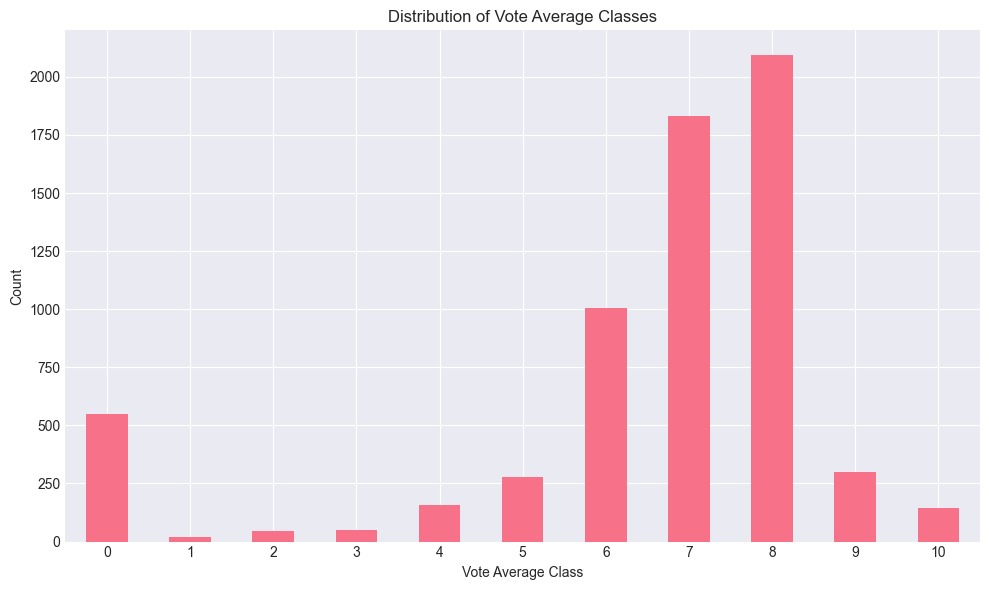

In [32]:
plt.figure(figsize=(10, 6))
df['vote_average'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Vote Average Class')
plt.ylabel('Count')
plt.title('Distribution of Vote Average Classes')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
# Calculate validation predictions for comparison
dfVal = pd.read_csv(dfClassValFile)
X_val = dfVal.drop(columns=[TARGET_COL])
y_val = dfVal[TARGET_COL]
y_pred_val = clf.predict(X_val)

val_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_val),
    'Precision': precision_score(y_val, y_pred_val, average='weighted', zero_division=0),
    'Recall': recall_score(y_val, y_pred_val, average='weighted', zero_division=0),
    'F1 Score': f1_score(y_val, y_pred_val, average='weighted', zero_division=0),
    'Balanced Accuracy': balanced_accuracy_score(y_val, y_pred_val)
}

# Create comparison dataframe
comparison_data = {
    'Metric': list(val_metrics.keys()),
    'Validation': list(val_metrics.values()),
    'Test': [test_metrics['Accuracy'], test_metrics['Precision (weighted)'], 
             test_metrics['Recall (weighted)'], test_metrics['F1 Score (weighted)'],
             test_metrics['Balanced Accuracy']]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

           Metric  Validation     Test
         Accuracy    0.508230 0.492798
        Precision    0.482363 0.469969
           Recall    0.508230 0.492798
         F1 Score    0.491798 0.476805
Balanced Accuracy    0.306394 0.293993


come visibile nell'output subito sopra la differenza fra le metriche sul test di validazione e quello di test sono molto simili

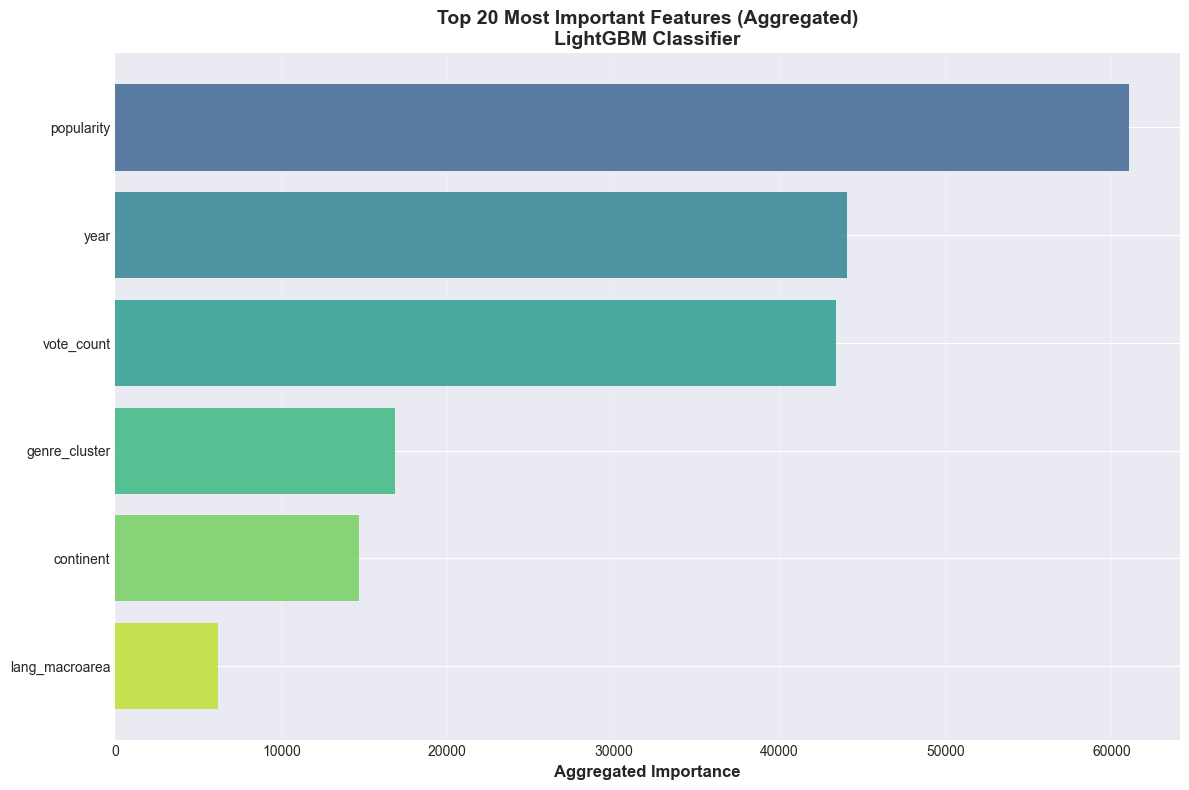

In [34]:
# Define the categorical feature groups
categorical_groups = {
    'genre_cluster': [f'genre_cluster_{i}' for i in range(6)],
    'continent': ['continent_Africa', 'continent_Asia', 'continent_Europe', 
                  'continent_North America', 'continent_Oceania', 'continent_South America'],
    'lang_macroarea': ['lang_macroarea_Africa', 'lang_macroarea_Eurasia', 
                       'lang_macroarea_North America', 'lang_macroarea_Papunesia', 
                       'lang_macroarea_South America']
}

# Create a mapping from individual feature to its group
feature_to_group = {}
for group_name, features in categorical_groups.items():
    for feature in features:
        feature_to_group[feature] = group_name

# Get feature importances from regression model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

# Aggregate feature importances
aggregated_importance = {}

for idx, row in feature_importance.iterrows():
    feature_name = row['feature']
    importance = row['importance']
    
    # If it's a one-hot encoded feature, use the group name
    # Otherwise, keep the original feature name
    base_name = feature_to_group.get(feature_name, feature_name)
    
    if base_name in aggregated_importance:
        aggregated_importance[base_name] += importance
    else:
        aggregated_importance[base_name] = importance

# Create DataFrame with aggregated importances
aggregated_df = pd.DataFrame({
    'feature': list(aggregated_importance.keys()),
    'importance': list(aggregated_importance.values())
}).sort_values('importance', ascending=False)

# Plot aggregated importances
plt.figure(figsize=(12, 8))
top_n = 20
top_features = aggregated_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Aggregated Importance', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features (Aggregated)\nLightGBM Classifier', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

come vediamo dal plot delle feature importance le features che risultano più importanti sono popularity, year e vote_count

ho inoltre aggregato le features che erano state divise durante il one hot encoding così da vedere l'importanza delle feature categoriche

In [35]:
print("FINAL MODEL SUMMARY")
print("Model: LightGBM Classifier")
print("Parameters:")
for param, value in clf.get_params().items():
    if param in ['learning_rate', 'max_depth', 'n_estimators', 'num_leaves', 'random_state']:
        print(f"  {param}: {value}")

print("\nTest Set Performance:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")


FINAL MODEL SUMMARY
Model: LightGBM Classifier
Parameters:
  learning_rate: 0.015
  max_depth: 10
  n_estimators: 250
  num_leaves: 70
  random_state: 42

Test Set Performance:
  Accuracy: 0.4928
  Precision (weighted): 0.4700
  Recall (weighted): 0.4928
  F1 Score (weighted): 0.4768
  Balanced Accuracy: 0.2940
  ROC-AUC: 0.7878


### regressione

#### prima analisi

##### parametri e funzioni

In [36]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=10000),
    'ElasticNet': ElasticNet(random_state=42, max_iter=10000),
    'KNeighbors': KNeighborsRegressor(),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

In [37]:
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2]
    },
    
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    },
    
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'solver': ['auto', 'svd']
    },
    
    'Lasso': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.2, 0.5, 0.8]
    },
    
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50],
        'max_depth': [-1]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6]
    },
    
    'CatBoost': {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6]
    }
}

In [38]:
def train_regressors(X_train, y_train, X_val, y_val, param_grids, models, n_jobs, cv_folds=5):
    """Train multiple regressors with GridSearchCV"""
    results = {}
    best_models = {}
    
    print(f"Inizio Grid Search con {cv_folds}-Fold CV su {n_jobs} cores")
    
    for model_name, model in models.items():
        print(f"\n[{datetime.now().strftime('%H:%M:%S')}] training {model_name}...")
        
        try:
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[model_name],
                cv=cv_folds,
                n_jobs=n_jobs,
                scoring='neg_mean_squared_error',
                verbose=1,
                return_train_score=True
            )
            
            grid_search.fit(X_train, y_train)
            
            best_models[model_name] = grid_search.best_estimator_
            
            train_pred = grid_search.predict(X_train)
            val_pred = grid_search.predict(X_val)
            
            def calculate_metrics(y_true, y_pred, set_name=''):
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_true, y_pred)
                r2 = r2_score(y_true, y_pred)
                
                # MAPE - gestisce divisioni per zero
                try:
                    mape = mean_absolute_percentage_error(y_true, y_pred)
                except:
                    # Calcolo manuale evitando divisione per zero
                    mask = y_true != 0
                    if mask.sum() > 0:
                        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
                    else:
                        mape = np.nan
                
                metrics = {
                    f'{set_name}_mse': mse,
                    f'{set_name}_rmse': rmse,
                    f'{set_name}_mae': mae,
                    f'{set_name}_r2': r2,
                    f'{set_name}_mape': mape
                }
                
                return metrics
            
            model_results = {
                'model_name': model_name,
                'best_params': grid_search.best_params_,
                'cv_mean_score': -grid_search.best_score_,  # Negativo perché GridSearch usa neg_mse
                'cv_std_score': grid_search.cv_results_['std_test_score'][grid_search.best_index_]
            }
            
            model_results.update(calculate_metrics(y_train, train_pred, 'train'))
            model_results.update(calculate_metrics(y_val, val_pred, 'val'))
            
            results[model_name] = model_results
            
            print(f"Miglior CV MSE: {model_results['cv_mean_score']:.4f}")
            print(f"Validation MSE: {model_results['val_mse']:.4f}")
            print(f"Validation RMSE: {model_results['val_rmse']:.4f}")
            print(f"Validation MAE: {model_results['val_mae']:.4f}")
            print(f"Validation R²: {model_results['val_r2']:.4f}")
            print(f"Validation MAPE: {model_results['val_mape']:.2f}%")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue
    
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Tutti i modelli sono stati allenati!")
    
    # Crea DataFrame con risultati
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('val_r2', ascending=False)  # Ordina per R² (più alto è meglio)
    
    print("\nCONFRONTO MODELLI SU VALIDATION SET")
    summary_cols = ['cv_mean_score', 'cv_std_score',
                    'train_mse', 'train_rmse', 'train_mae', 'train_r2',
                    'val_mse', 'val_rmse', 'val_mae', 'val_r2', 'val_mape']
    
    summary_table = results_df[summary_cols].round(4)
    print(summary_table.to_string())
    
    best_model_name = results_df.index[0]
    print(f"\nMIGLIOR MODELLO (su Validation): {best_model_name}")
    
    return results_df, best_models

In [39]:
def plot_regression_results(results_df, top_n=10):
    """Crea tutti i plot per confrontare i risultati dei regressori"""
    
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    fig = plt.figure(figsize=(20, 12))
    
    top_models = results_df.head(top_n)
    
    # 1. Validation Metrics Comparison
    ax1 = plt.subplot(2, 3, 1)
    metrics_to_plot = ['val_mse', 'val_rmse', 'val_mae', 'val_r2']
    
    # Normalizza le metriche per visualizzazione (tranne R² che è già 0-1)
    plot_data = top_models[metrics_to_plot].copy()
    for col in ['val_mse', 'val_rmse', 'val_mae']:
        max_val = plot_data[col].max()
        if max_val > 0:
            plot_data[col] = plot_data[col] / max_val
    
    x = np.arange(len(top_models))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        offset = width * (i - 1.5)
        ax1.bar(x + offset, plot_data[metric], width, 
                label=metric.replace('val_', '').upper())
    
    ax1.set_xlabel('Models', fontsize=10)
    ax1.set_ylabel('Normalized Score', fontsize=10)
    ax1.set_title('Top 10 Models - Validation Metrics Comparison\n(Normalized)', 
                  fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    ax1.legend(fontsize=8)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Train vs Validation R² Score
    ax2 = plt.subplot(2, 3, 2)
    x_pos = np.arange(len(top_models))
    ax2.barh(x_pos - 0.2, top_models['train_r2'], 0.4, label='Train R²', alpha=0.8)
    ax2.barh(x_pos + 0.2, top_models['val_r2'], 0.4, label='Validation R²', alpha=0.8)
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels(top_models.index, fontsize=8)
    ax2.set_xlabel('R² Score', fontsize=10)
    ax2.set_title('Train vs Validation R² Score\n(Overfitting Check)', 
                  fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Cross-Validation Scores (MSE)
    ax3 = plt.subplot(2, 3, 3)
    ax3.errorbar(range(len(top_models)), top_models['cv_mean_score'], 
                 yerr=top_models['cv_std_score'], fmt='o-', capsize=5, 
                 capthick=2, markersize=8, linewidth=2)
    ax3.set_xticks(range(len(top_models)))
    ax3.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    ax3.set_ylabel('CV MSE', fontsize=10)
    ax3.set_xlabel('Models', fontsize=10)
    ax3.set_title('Cross-Validation MSE (Mean ± Std)\n(Lower is Better)', 
                  fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Heatmap
    ax4 = plt.subplot(2, 3, 4)
    heatmap_metrics = ['cv_mean_score', 'train_rmse', 'train_mae', 'train_r2',
                       'val_rmse', 'val_mae', 'val_r2']
    
    heatmap_data = top_models[heatmap_metrics].apply(pd.to_numeric, errors='coerce').T
    heatmap_data = heatmap_data.fillna(0)
    
    # Inverti le metriche di errore per il colore (più basso è meglio)
    for metric in ['cv_mean_score', 'train_rmse', 'train_mae', 'val_rmse', 'val_mae']:
        if metric in heatmap_data.index:
            max_val = heatmap_data.loc[metric].max()
            if max_val > 0:
                heatmap_data.loc[metric] = 1 - (heatmap_data.loc[metric] / max_val)
    
    sns.heatmap(heatmap_data, annot=False, cmap='YlGnBu', 
                cbar_kws={'label': 'Score (normalized)'}, ax=ax4, linewidths=0.5)
    ax4.set_title('Performance Heatmap - All Metrics', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Models', fontsize=10)
    ax4.set_yticklabels([m.replace('_', ' ').upper() for m in heatmap_metrics], 
                         rotation=0, fontsize=8)
    ax4.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    
    # 5. Overfitting Analysis (R²)
    ax5 = plt.subplot(2, 3, 5)
    overfitting_gap = top_models['train_r2'] - top_models['val_r2']
    colors = ['red' if gap > 0.15 else 'orange' if gap > 0.08 else 'green' 
              for gap in overfitting_gap]
    bars = ax5.barh(range(len(top_models)), overfitting_gap, color=colors, alpha=0.7)
    ax5.set_yticks(range(len(top_models)))
    ax5.set_yticklabels(top_models.index, fontsize=8)
    ax5.set_xlabel('Train R² - Validation R²', fontsize=10)
    ax5.set_title('Overfitting Analysis\n(Green=Good, Orange=Moderate, Red=High)', 
                  fontsize=12, fontweight='bold')
    ax5.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax5.axvline(x=0.08, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    ax5.axvline(x=0.15, color='red', linestyle=':', linewidth=1, alpha=0.5)
    ax5.grid(axis='x', alpha=0.3)
    
    # 6. RMSE vs MAE Comparison
    ax6 = plt.subplot(2, 3, 6)
    x_pos = np.arange(len(top_models))
    width = 0.35
    ax6.bar(x_pos - width/2, top_models['val_rmse'], width, 
            label='Validation RMSE', alpha=0.8)
    ax6.bar(x_pos + width/2, top_models['val_mae'], width, 
            label='Validation MAE', alpha=0.8)
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(top_models.index, rotation=45, ha='right', fontsize=8)
    ax6.set_ylabel('Error', fontsize=10)
    ax6.set_title('RMSE vs MAE Comparison\n(Lower is Better)', 
                  fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 7: Metriche in dettaglio
    fig3, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    metrics = ['val_r2', 'val_mse', 'val_rmse', 
               'val_mae', 'val_mape', 'cv_mean_score']
    titles = ['Validation R² (Higher is Better)', 'Validation MSE (Lower is Better)', 
              'Validation RMSE (Lower is Better)', 'Validation MAE (Lower is Better)', 
              'Validation MAPE % (Lower is Better)', 'CV Mean MSE (Lower is Better)']
    ascending_order = [False, True, True, True, True, True]  # R² più alto è meglio, altri più basso
    
    for idx, (metric, title, ascending) in enumerate(zip(metrics, titles, ascending_order)):
        metric_data = pd.to_numeric(results_df[metric], errors='coerce')
        sorted_data = results_df.copy()
        sorted_data[metric] = metric_data
        sorted_data = sorted_data.dropna(subset=[metric])
        sorted_data = sorted_data.sort_values(metric, ascending=ascending)
        
        values = sorted_data[metric].values
        
        if values.max() - values.min() > 0:
            if ascending:  # Per metriche dove più basso è meglio
                normalized = 1 - (values - values.min()) / (values.max() - values.min())
            else:  # Per R² dove più alto è meglio
                normalized = (values - values.min()) / (values.max() - values.min())
        else:
            normalized = np.ones_like(values) * 0.5
        
        colors_map = plt.cm.RdYlGn(normalized)
        
        axes[idx].barh(range(len(sorted_data)), values, color=colors_map)
        axes[idx].set_yticks(range(len(sorted_data)))
        axes[idx].set_yticklabels(sorted_data.index, fontsize=9)
        axes[idx].set_xlabel('Score', fontsize=10)
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        
        for i, v in enumerate(values):
            axes[idx].text(v + (values.max() - values.min()) * 0.01, i, 
                          f'{v:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [40]:
def plot_predictions_vs_actual(model, model_name, X_train, y_train, X_val, y_val):
    """Plot delle predizioni vs valori reali per train, validation e test set"""
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    n_plots = 2 
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    if n_plots == 2:
        axes = [axes[0], axes[1]]
    
    # Training set
    axes[0].scatter(y_train, train_pred, alpha=0.5, s=20)
    axes[0].plot([y_train.min(), y_train.max()], 
                 [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Values', fontsize=11)
    axes[0].set_ylabel('Predicted Values', fontsize=11)
    axes[0].set_title(f'{model_name} - Training Set\nR² = {r2_score(y_train, train_pred):.4f}', 
                      fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Validation set
    axes[1].scatter(y_val, val_pred, alpha=0.5, s=20, color='orange')
    axes[1].plot([y_val.min(), y_val.max()], 
                 [y_val.min(), y_val.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Values', fontsize=11)
    axes[1].set_ylabel('Predicted Values', fontsize=11)
    axes[1].set_title(f'{model_name} - Validation Set\nR² = {r2_score(y_val, val_pred):.4f}', 
                      fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [41]:
def plot_residuals(model, model_name, X_val, y_val):
    """Plot dei residui per analizzare la qualità delle predizioni"""
    
    val_pred = model.predict(X_val)
    residuals = y_val - val_pred
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Residuals vs Predicted
    axes[0].scatter(val_pred, residuals, alpha=0.5, s=20)
    axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0].set_xlabel('Predicted Values', fontsize=11)
    axes[0].set_ylabel('Residuals', fontsize=11)
    axes[0].set_title(f'{model_name} - Residual Plot', fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # 2. Histogram of Residuals
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Residuals', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title(f'{model_name} - Residuals Distribution', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    # 3. Q-Q Plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title(f'{model_name} - Q-Q Plot', fontsize=12, fontweight='bold')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calcola statistiche sui residui
    print(f"\n{model_name} - Residuals Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std: {residuals.std():.4f}")
    print(f"Min: {residuals.min():.4f}")
    print(f"Max: {residuals.max():.4f}")


##### training

In [42]:
df_train = pd.read_csv(dfRegImBalancedFile)
df_val = pd.read_csv(dfRegValFile)

# 2. Separa features e target
X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]
X_val = df_val.drop(columns=[TARGET_COL])
y_val = df_val[TARGET_COL]

In [43]:
results_df, best_models = train_regressors(
    X_train, y_train, X_val, y_val, 
    param_grids, models, n_jobs, cv_folds=5
)

Inizio Grid Search con 5-Fold CV su 18 cores

[00:18:27] training RandomForest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Miglior CV MSE: 1.3400
Validation MSE: 1.2528
Validation RMSE: 1.1193
Validation MAE: 0.7301
Validation R²: 0.7643
Validation MAPE: 72714780323850.70%

[00:19:22] training SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV MSE: 4.4019
Validation MSE: 3.9396
Validation RMSE: 1.9848
Validation MAE: 1.2161
Validation R²: 0.2588
Validation MAPE: 1829178753537393.00%

[00:19:48] training AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Miglior CV MSE: 1.4420
Validation MSE: 1.3995
Validation RMSE: 1.1830
Validation MAE: 0.7932
Validation R²: 0.7367
Validation MAPE: 62268120113503.55%

[00:19:54] training GradientBoosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Miglior CV MSE: 1.3719
Validation MSE: 1.2783
Validation RMSE: 1.1306
Validation MAE: 0.7449
Validation R²: 0.7595
Vali

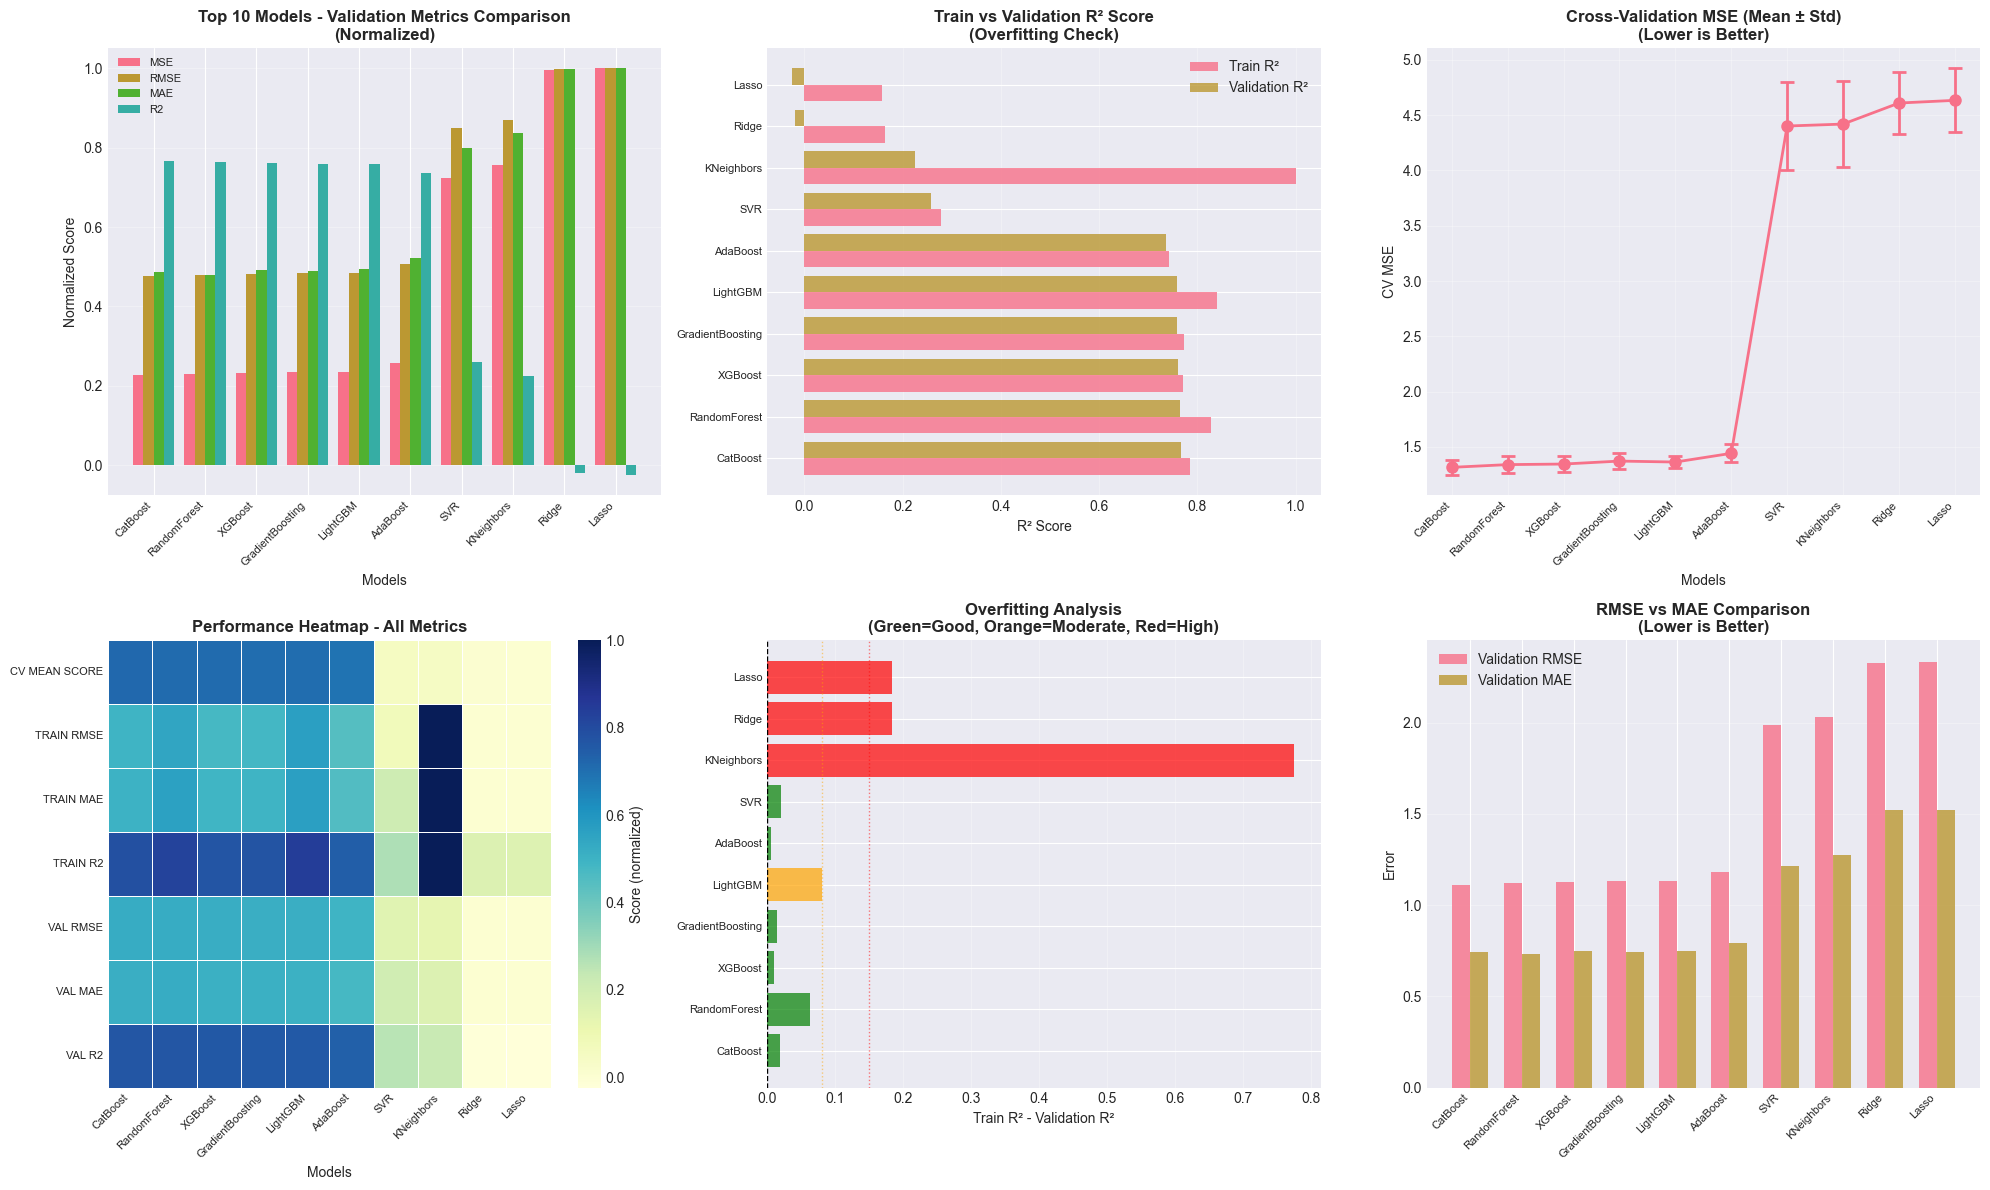

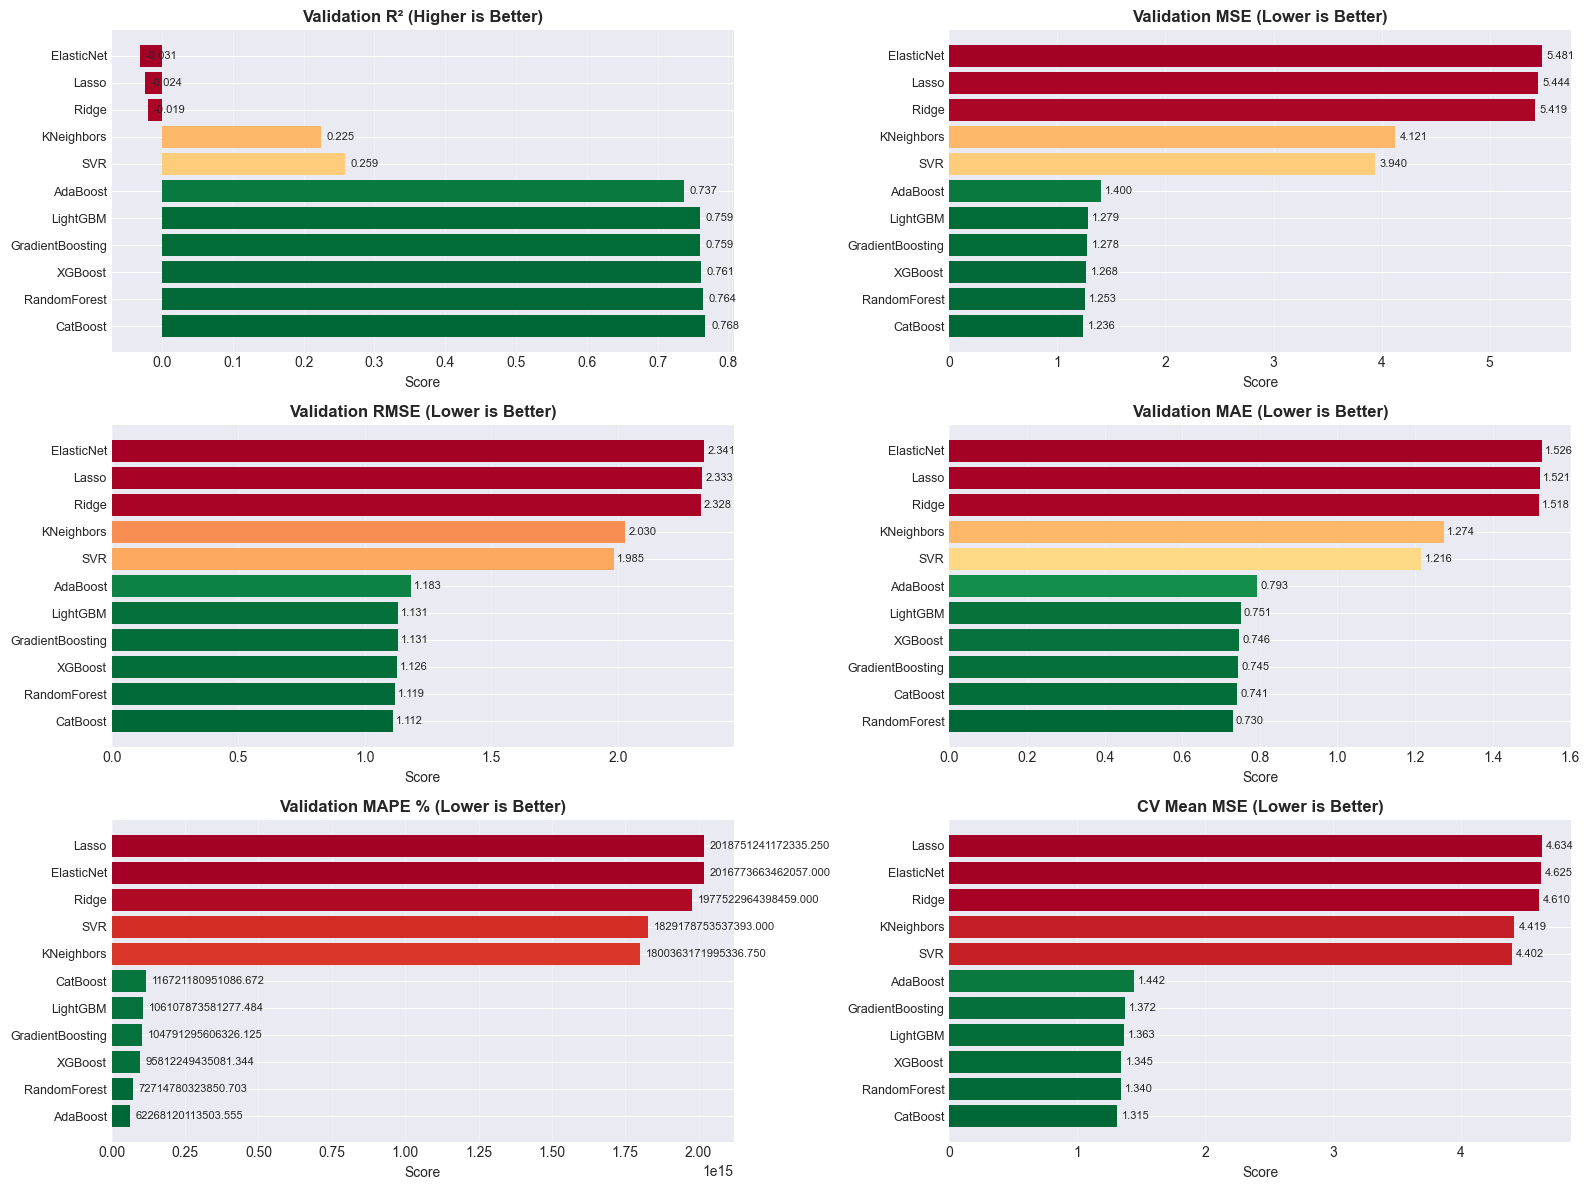

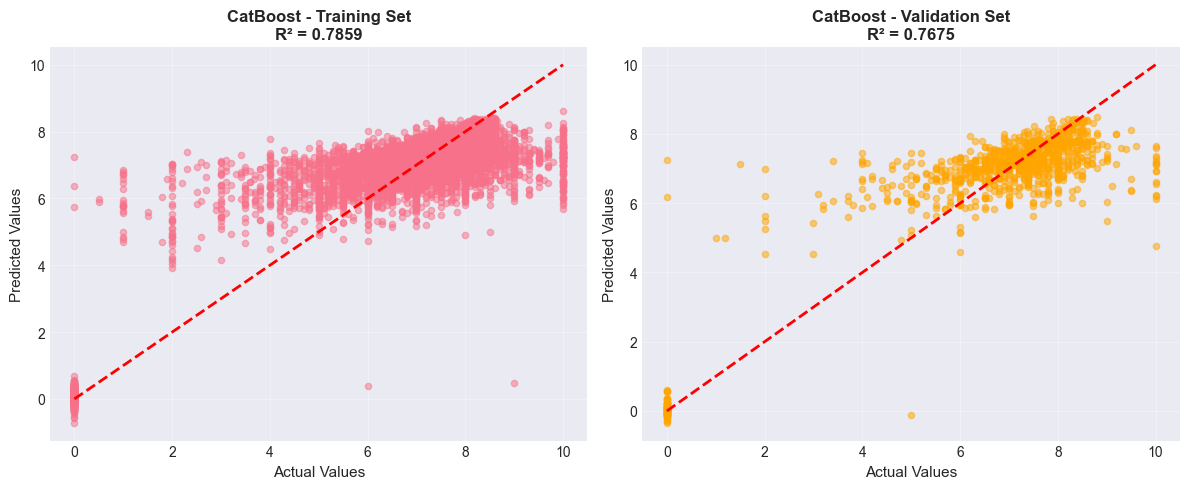

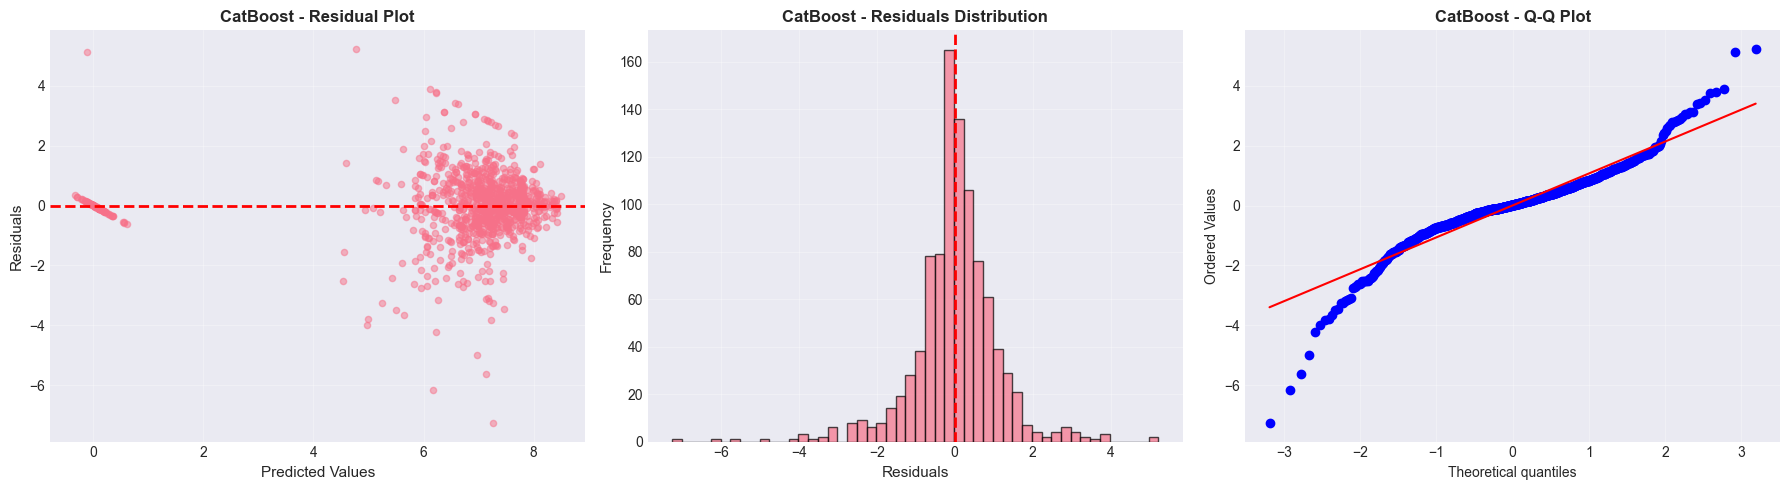


CatBoost - Residuals Statistics:
Mean: 0.0021
Std: 1.1122
Min: -7.2535
Max: 5.2214


In [44]:
plot_regression_results(results_df, top_n=10)

# 5. Analizza miglior modello
best_model_name = results_df.index[0]
best_model = best_models[best_model_name]

plot_predictions_vs_actual(
    best_model, best_model_name,
    X_train, y_train, X_val, y_val
)

plot_residuals(best_model, best_model_name, X_val, y_val)

#### riassunto e fine tuning

come vediamo dai risultati ottenuti CatBoost è l'algoritmo che ottiene i risultati migliori, per quanto altri modelli (AdaBoost, GradientBoosting, XGBoost, RandomForest) gli si avvicinino molto

come precedentemente effettuato procedo con il fine tuning del modello per migliorare ulteriolmente i risultati

In [45]:
initial_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6]
}

In [46]:
print(f"\nTesting {np.prod([len(v) for v in initial_param_grid.values()])} parameter combinations")

initial_grid_search = GridSearchCV(
    estimator=CatBoostRegressor(random_state=42, verbose=0),
    param_grid=initial_param_grid,
    cv=5,
    n_jobs=n_jobs,
    scoring='neg_mean_squared_error',
    verbose=2,
    return_train_score=True
)

print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Starting initial grid search...")
initial_grid_search.fit(X_train, y_train)
print(f"[{datetime.now().strftime('%H:%M:%S')}] Initial grid search completed!")


Testing 12 parameter combinations

[00:20:38] Starting initial grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[00:20:43] Initial grid search completed!


In [47]:
print(f"Best CV Score: {initial_grid_search.best_score_:.4f}")
print(f"Best Parameters: {initial_grid_search.best_params_}")

initial_best_model = initial_grid_search.best_estimator_
val_pred = initial_best_model.predict(X_val)

print("\nValidation Set Metrics:")
print(f"  Mean Squared Error: {mean_squared_error(y_val, val_pred):.4f}")
print(f"  Root Mean Square Error: {np.sqrt(mean_squared_error(y_val, val_pred)):.4f}")
print(f"  Mean Absolute Error: {mean_absolute_error(y_val, val_pred):.4f}")
print(f"  R-squared: {r2_score(y_val, val_pred):.4f}")

Best CV Score: -1.3153
Best Parameters: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

Validation Set Metrics:
  Mean Squared Error: 1.2357
  Root Mean Square Error: 1.1116
  Mean Absolute Error: 0.7413
  R-squared: 0.7675


In [48]:
initial_best_model.get_params()

{'loss_function': 'RMSE',
 'verbose': 0,
 'random_state': 42,
 'depth': 6,
 'iterations': 100,
 'learning_rate': 0.1}

In [49]:
# https://catboost.ai/docs/en/concepts/python-reference_catboostregressor
# catboost ha davvero molti parametri settabili, qui mi limiterò o modificare quelli che avevo
# precedentemente impostato ed aggiungerò solo una nuova loss_function
fine_tune_param_grid_light = {
    'iterations': [100, 70, 130],
    'learning_rate': [0.1, 0.05, 0.2],
    'depth': [6, 10, 14],
    'loss_function': ['RMSE', 'MAPE'] # MAPE: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
}

In [50]:
serializationFile = "output/regression_fine_tune_grid_search_light.pkl"
if not os.path.isfile(serializationFile):
    fine_tune_grid_search_light = GridSearchCV(
        estimator=CatBoostRegressor(random_state=42, verbose=0),
        param_grid=fine_tune_param_grid_light,
        cv=10,
        n_jobs=n_jobs,
        scoring='neg_mean_squared_error',
        verbose=4,
        return_train_score=True
    )
    print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Starting light fine-tuning...")
    fine_tune_grid_search_light.fit(X_train, y_train)
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Light fine-tuning completed!")
    with open (serializationFile, "wb") as f:
        pickle.dump(fine_tune_grid_search_light, f)

with open (serializationFile, "rb") as f:
    fine_tune_grid_search_light = pickle.load(f)
    
print(f"Best CV Score: {fine_tune_grid_search_light.best_score_:.4f}")
print(f"Best Parameters: {fine_tune_grid_search_light.best_params_}")


[00:20:43] Starting light fine-tuning...
Fitting 10 folds for each of 54 candidates, totalling 540 fits
[00:29:20] Light fine-tuning completed!
Best CV Score: -1.2975
Best Parameters: {'depth': 10, 'iterations': 70, 'learning_rate': 0.1, 'loss_function': 'RMSE'}


In [51]:
fine_tuned_model = fine_tune_grid_search_light.best_estimator_
val_pred_ft = fine_tuned_model.predict(X_val)

print("\nValidation Set Metrics:")
print(f"  Mean Squared Error: {mean_squared_error(y_val, val_pred_ft):.4f}")
print(f"  Root Mean Square Error: {np.sqrt(mean_squared_error(y_val, val_pred_ft)):.4f}")
print(f"  Mean Absolute Error: {mean_absolute_error(y_val, val_pred_ft):.4f}")
print(f"  R-squared: {r2_score(y_val, val_pred_ft):.4f}")


Validation Set Metrics:
  Mean Squared Error: 1.2490
  Root Mean Square Error: 1.1176
  Mean Absolute Error: 0.7450
  R-squared: 0.7650


In [52]:
comparison_data = {
    'Model': ['Initial', 'Light Fine-Tuned'],
    'CV Score': [
        initial_grid_search.best_score_,
        fine_tune_grid_search_light.best_score_,
    ],
    'Val MSE': [
        mean_squared_error(y_val, val_pred),
        mean_squared_error(y_val, val_pred_ft),
    ],
    'Val RMSE': [
        np.sqrt(mean_squared_error(y_val, val_pred)),
        np.sqrt(mean_squared_error(y_val, val_pred_ft)),
    ],
    'Val MAE': [
        mean_absolute_error(y_val, val_pred),
        mean_absolute_error(y_val, val_pred_ft),
    ],
    'Val R2': [
        r2_score(y_val, val_pred),
        r2_score(y_val, val_pred_ft),
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("MODEL COMPARISON")
print(comparison_df.to_string(index=False))

MODEL COMPARISON
           Model  CV Score  Val MSE  Val RMSE  Val MAE   Val R2
         Initial -1.315321 1.235672  1.111608 0.741313 0.767512
Light Fine-Tuned -1.297481 1.249010  1.117591 0.744986 0.765002


come per il caso del dataset modificato per la classificazione (ovviamente parlo della versione non bilanciata) i risultati fra una run e l'altra non sono cambiati molto

la differenza importante è che il risultato qui sopra riportato indica che, per quanto i parametri risultati migliori nella prima grid search forssero presenti anche nella seconda run, il risultato migliore della seconda grid search sono parametri leggermenti diversi, che però ottengono risultati peggiori

Questo è dovuto al fatto che il valore di cross validation precedente fosse impostato a 5, mentre nella seconda grid search, con i nuovi parametri a 10

Ciò significa che gli stessi parametri di prima hanno raggiunto un risultato peggiore una volta che il numero di test è aumentato

Per quanto i valori siano peggiorati non lo sono di molto e, in entrambi i casi, sono accettabili

Procedo quindi ad allenare il regressore finale e a calcolare le meetriche sul dataset di test, utilizzando i nuovi migliori parametri trovati:
* 'loss_function': 'RMSE',
* 'verbose': 0,
* 'random_state': 42,
* 'depth': 10,
* 'iterations': 70,
* 'learning_rate': 0.1

In [53]:
df_train = pd.read_csv(dfRegImBalancedFile)
df_test = pd.read_csv(dfRegTestFile)

X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

In [54]:
reg = CatBoostRegressor(
    loss_function='RMSE',
    depth=10,
    iterations=70,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)

print(f"[{datetime.now().strftime('%H:%M:%S')}] Training final regression model...")
reg.fit(X_train, y_train)
print(f"[{datetime.now().strftime('%H:%M:%S')}] Training completed!")

[00:29:20] Training final regression model...
[00:29:21] Training completed!


In [55]:
print("TEST SET METRICS - FINAL MODEL (CatBoost Regressor)")

test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# MAPE 
mask = y_test != 0
test_mape = np.mean(np.abs((y_test[mask] - y_pred_test[mask]) / y_test[mask])) * 100

test_metrics = {
    'Mean Squared Error (MSE)': test_mse,
    'Root Mean Squared Error (RMSE)': test_rmse,
    'Mean Absolute Error (MAE)': test_mae,
    'R-squared (R²)': test_r2,
    'Mean Absolute Percentage Error (MAPE %)': test_mape
}

for metric, value in test_metrics.items():
    if 'MAPE' in metric:
        print(f"{metric:.<45} {value:.2f}%")
    else:
        print(f"{metric:.<45} {value:.4f}")

TEST SET METRICS - FINAL MODEL (CatBoost Regressor)
Mean Squared Error (MSE)..................... 1.9811
Root Mean Squared Error (RMSE)............... 1.4075
Mean Absolute Error (MAE).................... 0.8673
R-squared (R²)............................... 0.6301
Mean Absolute Percentage Error (MAPE %)...... 16.71%


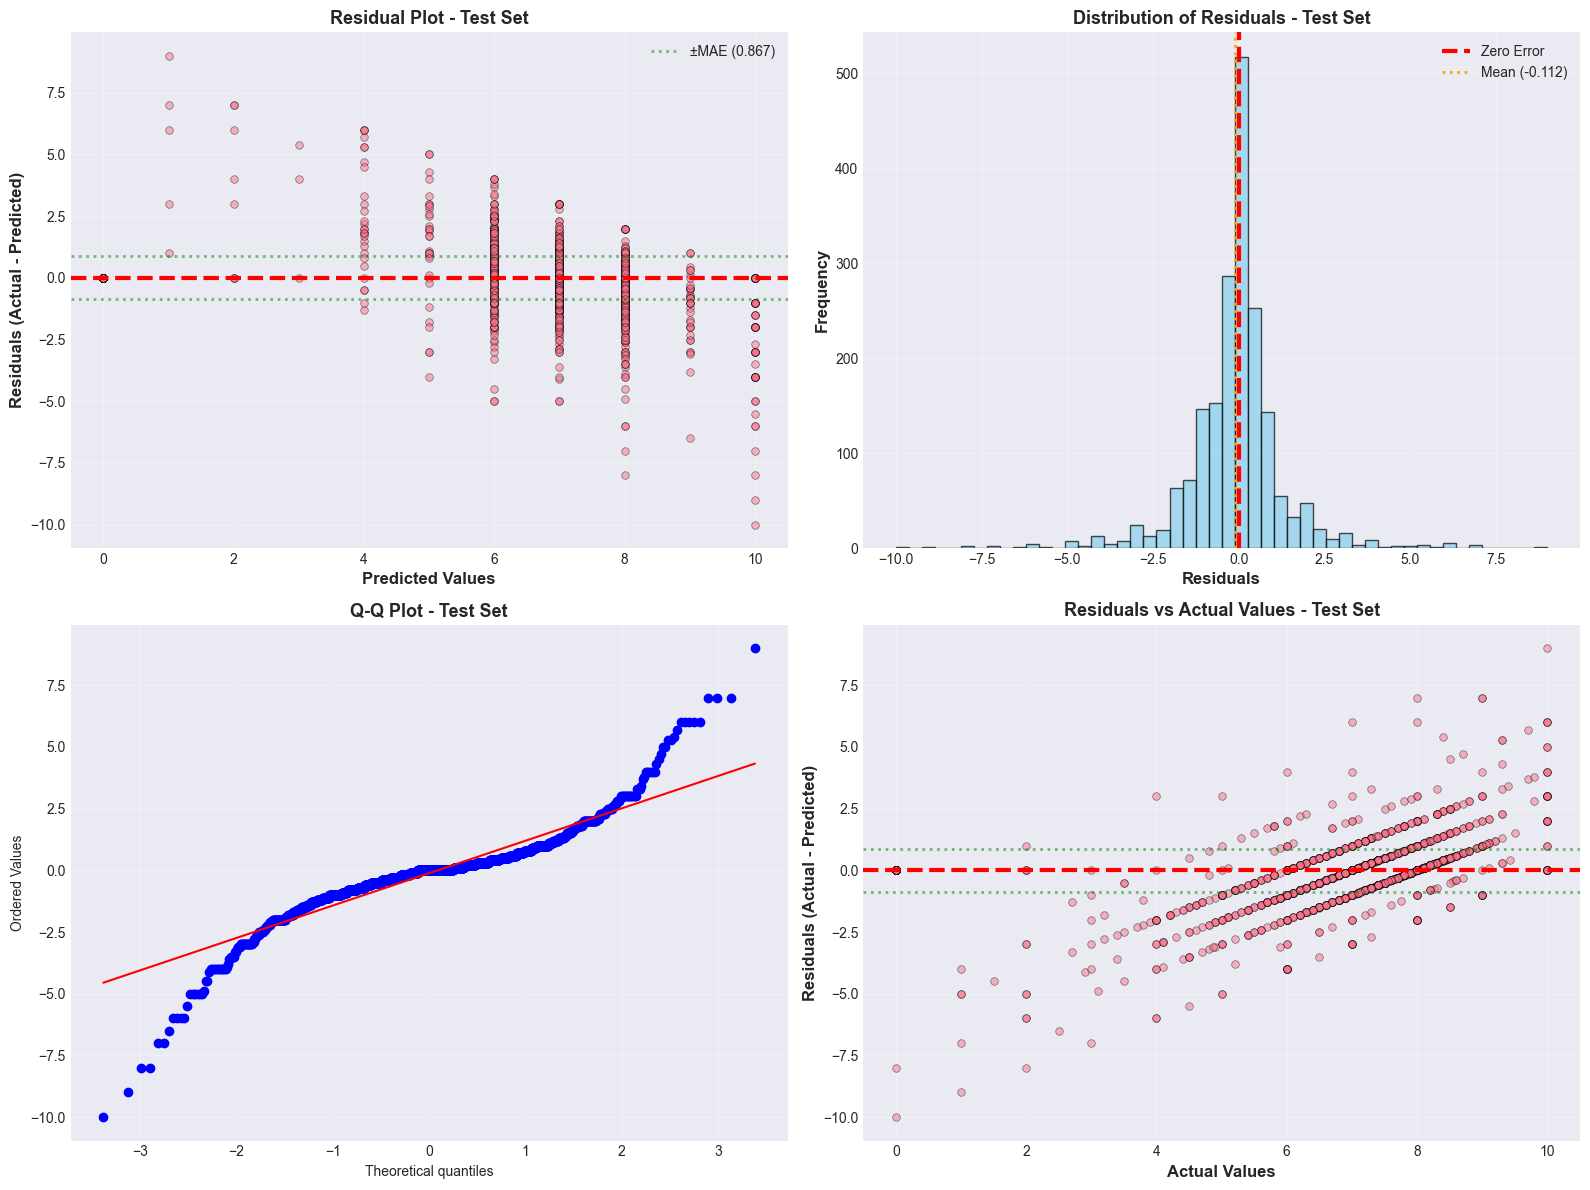

RESIDUAL STATISTICS - TEST SET
Mean of Residuals:............................... -0.1124
Std Dev of Residuals:............................ 1.4030
Min Residual (Under-prediction):................. -10.0000
Max Residual (Over-prediction):.................. 9.0000
Median Absolute Residual:........................ 0.5000


In [56]:
# Residuals
residuals_test = y_test - y_pred_test

residuals_test_plot = residuals_test
y_pred_test_resid_plot = y_pred_test
y_test_resid_plot = y_test

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residuals vs Predicted Values
axes[0, 0].scatter(y_pred_test_resid_plot, residuals_test_plot, alpha=0.5, s=30, 
                    edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=3)
axes[0, 0].axhline(y=test_mae, color='g', linestyle=':', lw=2, alpha=0.5, 
                    label=f'±MAE ({test_mae:.3f})')
axes[0, 0].axhline(y=-test_mae, color='g', linestyle=':', lw=2, alpha=0.5)
axes[0, 0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Residual Plot - Test Set', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Histogram of Residuals
residuals_array = residuals_test.values if hasattr(residuals_test, 'values') else residuals_test
axes[0, 1].hist(residuals_array, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=3, label='Zero Error')
axes[0, 1].axvline(x=residuals_array.mean(), color='orange', linestyle=':', lw=2, 
                    label=f'Mean ({residuals_array.mean():.3f})')
axes[0, 1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Distribution of Residuals - Test Set', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q Plot
stats.probplot(residuals_array, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot - Test Set', 
                      fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Residuals vs Actual Values
axes[1, 1].scatter(y_test_resid_plot, residuals_test_plot, alpha=0.5, s=30, 
                    edgecolors='black', linewidth=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=3)
axes[1, 1].axhline(y=test_mae, color='g', linestyle=':', lw=2, alpha=0.5)
axes[1, 1].axhline(y=-test_mae, color='g', linestyle=':', lw=2, alpha=0.5)
axes[1, 1].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Residuals vs Actual Values - Test Set', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("RESIDUAL STATISTICS - TEST SET")
print(f"Mean of Residuals:............................... {residuals_array.mean():.4f}")
print(f"Std Dev of Residuals:............................ {residuals_array.std():.4f}")
print(f"Min Residual (Under-prediction):................. {residuals_array.min():.4f}")
print(f"Max Residual (Over-prediction):.................. {residuals_array.max():.4f}")
print(f"Median Absolute Residual:........................ {np.median(np.abs(residuals_array)):.4f}")


i risultati ottenuti sono buoni, di fatti sia la media dei residuals che il valore assoluto mediano sono vicino allo zero e la standard deviation è bassa

il valori di min e max redisual sono agli antipodi ma, come si vede dal secondo grafo (in alto a destra) e dal q-q plot i residual sono sempre abbastanza bassi tranne per degli errori alle code della distribuzione 

In [57]:
# Calculate validation predictions
df_val = pd.read_csv(dfRegValFile)
X_val = df_val.drop(columns=[TARGET_COL])
y_val = df_val[TARGET_COL]
y_pred_val = reg.predict(X_val)

val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Create comparison dataframe
comparison_data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Validation': [val_mse, val_rmse, val_mae, val_r2],
    'Test': [test_mse, test_rmse, test_mae, test_r2]
}

comparison_df = pd.DataFrame(comparison_data)

print("TRAIN / VALIDATION / TEST COMPARISON")
print(comparison_df.to_string(index=False))

TRAIN / VALIDATION / TEST COMPARISON
Metric  Validation     Test
   MSE    1.249010 1.981098
  RMSE    1.117591 1.407515
   MAE    0.744986 0.867285
    R²    0.765002 0.630102


i risultati fra il validation set e il test set sono simili come lo erano per il dataset di classificazione

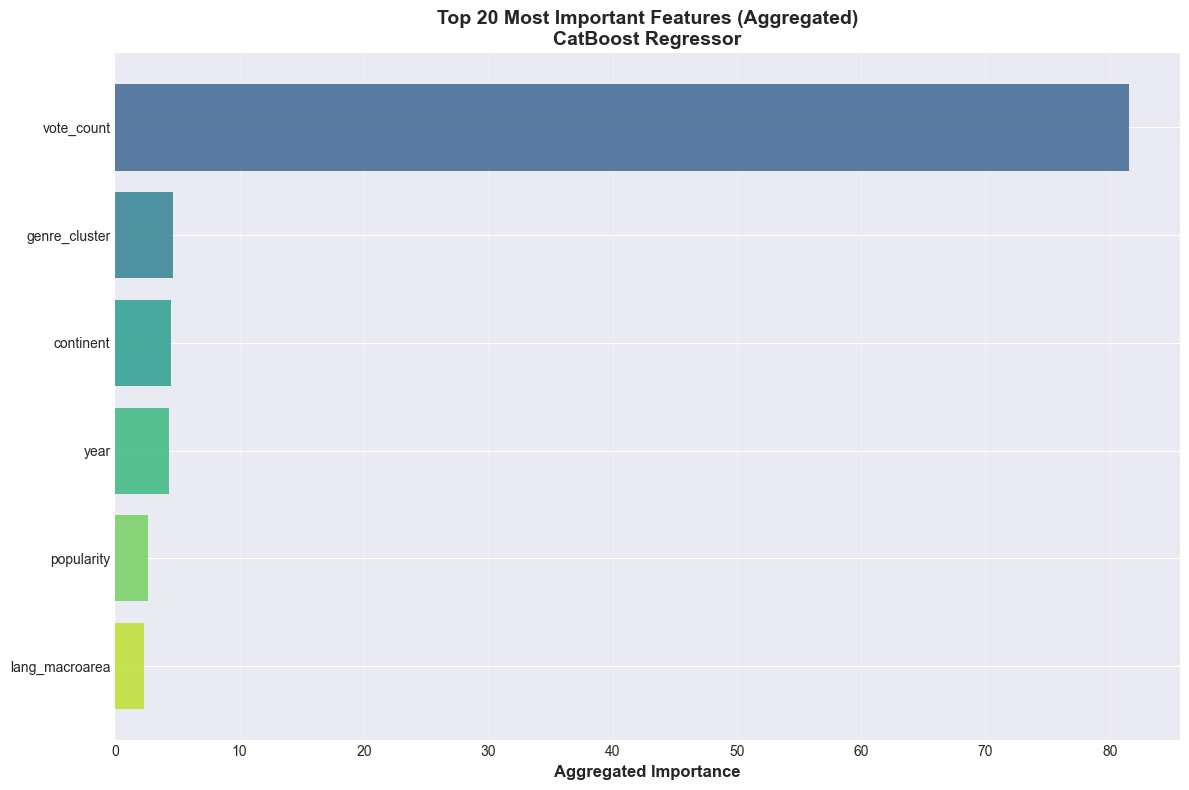

In [58]:
# Define the categorical feature groups (same as before)
categorical_groups = {
    'genre_cluster': [f'genre_cluster_{i}' for i in range(6)],
    'continent': ['continent_Africa', 'continent_Asia', 'continent_Europe', 
                  'continent_North America', 'continent_Oceania', 'continent_South America'],
    'lang_macroarea': ['lang_macroarea_Africa', 'lang_macroarea_Eurasia', 
                       'lang_macroarea_North America', 'lang_macroarea_Papunesia', 
                       'lang_macroarea_South America']
}

# Create a mapping from individual feature to its group
feature_to_group = {}
for group_name, features in categorical_groups.items():
    for feature in features:
        feature_to_group[feature] = group_name

# Get feature importances from regression model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg.feature_importances_
}).sort_values('importance', ascending=False)

# Aggregate feature importances
aggregated_importance = {}

for idx, row in feature_importance.iterrows():
    feature_name = row['feature']
    importance = row['importance']
    
    # If it's a one-hot encoded feature, use the group name
    # Otherwise, keep the original feature name
    base_name = feature_to_group.get(feature_name, feature_name)
    
    if base_name in aggregated_importance:
        aggregated_importance[base_name] += importance
    else:
        aggregated_importance[base_name] = importance

# Create DataFrame with aggregated importances
aggregated_df = pd.DataFrame({
    'feature': list(aggregated_importance.keys()),
    'importance': list(aggregated_importance.values())
}).sort_values('importance', ascending=False)

# Plot aggregated importances
plt.figure(figsize=(12, 8))
top_n = 20
top_features = aggregated_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Aggregated Importance', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features (Aggregated)\nCatBoost Regressor', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

a differenza del grado sulla feature importance precedente nel caso del regressore la colona vote_count ha avuto un'importanza molto più alta rispetto alle altre features

potrebbe essere interessante confrontare le performance di un regressore semplice che utilizza solo vote_count come feature per determinare vote_average con il regressore qui allenato

In [59]:
print("FINAL MODEL SUMMARY - REGRESSION")
print("Model: CatBoost Regressor")
print("Parameters:")
for param, value in reg.get_params().items():
    if param in ['loss_function', 'depth', 'iterations', 'learning_rate', 'random_state']:
        print(f"  {param}: {value}")

print("\nTest Set Performance:")
for metric, value in test_metrics.items():
    if 'MAPE' in metric:
        print(f"  {metric}: {value:.2f}%")
    else:
        print(f"  {metric}: {value:.4f}")

FINAL MODEL SUMMARY - REGRESSION
Model: CatBoost Regressor
Parameters:
  iterations: 70
  learning_rate: 0.1
  depth: 10
  loss_function: RMSE
  random_state: 42

Test Set Performance:
  Mean Squared Error (MSE): 1.9811
  Root Mean Squared Error (RMSE): 1.4075
  Mean Absolute Error (MAE): 0.8673
  R-squared (R²): 0.6301
  Mean Absolute Percentage Error (MAPE %): 16.71%
